In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import minimize
from tqdm import tqdm
import warnings
import os
import joblib
from datetime import datetime

In [44]:
# Configure plotting
plt.style.use("default")
sns.set_palette("husl")
warnings.filterwarnings("ignore")

In [45]:
# File paths
DATA_FILE = "Data.csv"
MODELS_DIR = "ctle_circuit_generation_with_DNN_models_V1"
PLOTS_DIR = "ctle_circuit_generation_with_DNN_models_V1"

In [46]:
# Target columns
TARGET_COLS = [
    "stage 1 0.1G attenuation",
    "stage 2 0.1G attenuation",
    "stage 1 3.5G attenuation",
    "stage 2 3.5G attenuation",
    "stage 1 7G attenuation",
    "stage 2 7G attenuation",
    "stage 1 14G attenuation",
    "stage 2 14G attenuation",
    "stage 1 28G attenuation",
    "stage 2 28G attenuation",
]

In [47]:
# Features to optimize in inverse design
FEATURES_TO_OPTIMIZE = ["fW", "current", "ind", "Rd", "Cs", "Rs"]

In [48]:
class IQROutlierCapper(BaseEstimator, TransformerMixin):
    """Custom transformer to cap outliers using IQR method"""

    def __init__(self, lower_bound_mult=1.5, upper_bound_mult=1.5):
        self.lower_bound_mult = lower_bound_mult
        self.upper_bound_mult = upper_bound_mult
        self.lower_bounds_ = {}
        self.upper_bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        for col in X.columns:
            if pd.api.types.is_numeric_dtype(X[col]) and not X[col].isnull().all():
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                self.lower_bounds_[col] = Q1 - (IQR * self.lower_bound_mult)
                self.upper_bounds_[col] = Q3 + (IQR * self.upper_bound_mult)
            else:
                self.lower_bounds_[col] = -np.inf
                self.upper_bounds_[col] = np.inf
        return self

    def transform(self, X):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        X_copy = X.copy()
        for col in X_copy.columns:
            if (
                col in self.lower_bounds_
                and pd.api.types.is_numeric_dtype(X_copy[col])
                and self.lower_bounds_[col] != -np.inf
                and self.upper_bounds_[col] != np.inf
            ):
                X_copy[col] = X_copy[col].clip(
                    lower=self.lower_bounds_[col], upper=self.upper_bounds_[col]
                )
        return X_copy

In [49]:
def setup_directories():
    """Create necessary directories for outputs"""
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.makedirs(PLOTS_DIR, exist_ok=True)

In [50]:
def visualize_data_overview(df):
    """comprehensive data overview visualizations"""

    # Dataset info
    print(f"Dataset shape: {df.shape}")
    print(f"Features: {df.shape[1] - len(TARGET_COLS)} columns")
    print(f"Targets: {len(TARGET_COLS)} columns")
    print(f"Missing values: {df.isnull().sum().sum()}")

    # 1. Dataset Overview
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("CTLE Dataset Overview", fontsize=16, fontweight="bold")

    # Missing values heatmap
    missing_data = df.isnull().sum()
    if missing_data.sum() > 0:
        axes[0, 0].bar(range(len(missing_data)), missing_data.values)
        axes[0, 0].set_title("Missing Values by Column")
        axes[0, 0].set_xlabel("Columns")
        axes[0, 0].set_ylabel("Missing Count")
        axes[0, 0].tick_params(axis="x", rotation=45)
    else:
        axes[0, 0].text(
            0.5,
            0.5,
            "No Missing Values!",
            ha="center",
            va="center",
            fontsize=14,
            color="green",
        )
        axes[0, 0].set_title("Missing Values Status")

    # Data types distribution
    dtype_counts = df.dtypes.value_counts()
    axes[0, 1].pie(dtype_counts.values, labels=dtype_counts.index, autopct="%1.1f%%")
    axes[0, 1].set_title("Data Types Distribution")

    # Feature vs Target correlation
    feature_cols = [col for col in df.columns if col not in TARGET_COLS]
    X = df[feature_cols].select_dtypes(include=[np.number])
    y = df[TARGET_COLS]

    if len(X.columns) > 0:
        corr_with_targets = []
        for target in TARGET_COLS:
            corr_vals = X.corrwith(df[target]).abs()
            corr_with_targets.extend(corr_vals.values)

        axes[1, 0].hist(corr_with_targets, bins=20, alpha=0.7, color="skyblue")
        axes[1, 0].set_title("Distribution of Feature-Target Correlations")
        axes[1, 0].set_xlabel("Absolute Correlation")
        axes[1, 0].set_ylabel("Frequency")

    # Target variables distribution
    target_stats = df[TARGET_COLS].describe().loc[["mean", "std"]].T
    x_pos = np.arange(len(TARGET_COLS))
    width = 0.35

    axes[1, 1].bar(
        x_pos - width / 2,
        target_stats["mean"],
        width,
        label="Mean",
        alpha=0.8,
        color="lightcoral",
    )
    axes[1, 1].bar(
        x_pos + width / 2,
        target_stats["std"],
        width,
        label="Std Dev",
        alpha=0.8,
        color="lightblue",
    )
    axes[1, 1].set_title("Target Variables: Mean vs Standard Deviation")
    axes[1, 1].set_xlabel("Target Variables")
    axes[1, 1].set_ylabel("Value")
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/01_data_overview.png", dpi=300, bbox_inches="tight")
    plt.show()

    # 2. Feature Distributions
    numeric_features = df.select_dtypes(include=[np.number]).columns
    n_features = len(numeric_features)

    if n_features > 0:
        n_cols = 4
        n_rows = (n_features + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
        fig.suptitle("Feature Distributions", fontsize=16, fontweight="bold")

        axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

        for i, col in enumerate(numeric_features):
            if i < len(axes):
                axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, color="lightgreen")
                axes[i].set_title(f"{col}")
                axes[i].set_xlabel("Value")
                axes[i].set_ylabel("Frequency")

                # Add statistics
                mean_val = df[col].mean()
                std_val = df[col].std()
                axes[i].axvline(
                    mean_val,
                    color="red",
                    linestyle="--",
                    alpha=0.7,
                    label=f"Mean: {mean_val:.2f}",
                )
                axes[i].legend()

        # Hide empty subplots
        for i in range(n_features, len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.savefig(
            f"{PLOTS_DIR}/02_feature_distributions.png", dpi=300, bbox_inches="tight"
        )
        plt.show()

    # 3. Target Correlation Matrix
    plt.figure(figsize=(12, 10))
    target_corr = df[TARGET_COLS].corr()
    mask = np.triu(np.ones_like(target_corr, dtype=bool))

    sns.heatmap(
        target_corr,
        mask=mask,
        annot=True,
        cmap="RdYlBu_r",
        center=0,
        square=True,
        fmt=".2f",
        cbar_kws={"shrink": 0.8},
    )
    plt.title("Target Variables Correlation Matrix", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/03_target_correlations.png", dpi=300, bbox_inches="tight")
    plt.show()

In [51]:
def visualize_preprocessing_effects(X_before, X_after, feature_names):
    """effects of preprocessing"""

    # Select few key features to show preprocessing effects
    key_features = FEATURES_TO_OPTIMIZE[:4]  # Show first 4 optimizable features

    fig, axes = plt.subplots(2, len(key_features), figsize=(20, 10))
    fig.suptitle(
        "Preprocessing Effects: Before vs After", fontsize=16, fontweight="bold"
    )

    for i, feature in enumerate(key_features):
        if feature in X_before.columns:
            # Before preprocessing
            axes[0, i].hist(
                X_before[feature].dropna(),
                bins=30,
                alpha=0.7,
                color="lightcoral",
                label="Original",
            )
            axes[0, i].set_title(f"{feature} - Original")
            axes[0, i].set_xlabel("Value")
            axes[0, i].set_ylabel("Frequency")

            # After preprocessing (find corresponding column in processed data)
            processed_col = None
            for col in feature_names:
                if feature in col:
                    processed_col = col
                    break

            if processed_col and processed_col in X_after.columns:
                axes[1, i].hist(
                    X_after[processed_col],
                    bins=30,
                    alpha=0.7,
                    color="lightblue",
                    label="Processed",
                )
                axes[1, i].set_title(f"{feature} - Processed")
                axes[1, i].set_xlabel("Standardized Value")
                axes[1, i].set_ylabel("Frequency")

    plt.tight_layout()
    plt.savefig(
        f"{PLOTS_DIR}/04_preprocessing_effects.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

In [52]:
def visualize_model_comparison(all_results, comparison_df):
    """comprehensive model comparison visualizations"""

    # 1. Overall Performance Comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle("Model Performance Comparison", fontsize=16, fontweight="bold")

    models = comparison_df["Model"].values
    metrics = ["Overall_RMSE", "Overall_MAE", "Overall_R²"]
    metric_names = ["RMSE", "MAE", "R²"]
    colors = ["lightcoral", "lightblue", "lightgreen"]

    for i, (metric, name, color) in enumerate(zip(metrics, metric_names, colors)):
        values = comparison_df[metric].values
        bars = axes[i].bar(models, values, color=color, alpha=0.8)
        axes[i].set_title(f"{name} Comparison")
        axes[i].set_ylabel(name)
        axes[i].tick_params(axis="x", rotation=45)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            axes[i].text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{value:.4f}",
                ha="center",
                va="bottom",
            )

    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/05_model_comparison.png", dpi=300, bbox_inches="tight")
    plt.show()

    # 2. Per-Target Performance Heatmap
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle("Per-Target Performance Heatmap", fontsize=16, fontweight="bold")

    metrics_data = {"RMSE": [], "MAE": [], "R²": []}

    for model_name in models:
        model_results = all_results[model_name]["per_target"]
        for metric in ["RMSE", "MAE", "R²"]:
            row = [model_results[target][metric] for target in TARGET_COLS]
            metrics_data[metric].append(row)

    for i, (metric, data) in enumerate(metrics_data.items()):
        df_metric = pd.DataFrame(data, index=models, columns=TARGET_COLS)

        # Use different color maps for different metrics
        cmap = "Reds" if metric in ["RMSE", "MAE"] else "Greens"

        sns.heatmap(
            df_metric,
            annot=True,
            fmt=".3f",
            cmap=cmap,
            ax=axes[i],
            cbar_kws={"shrink": 0.8},
        )
        axes[i].set_title(f"{metric} by Target Variable")
        axes[i].set_xlabel("Target Variables")
        axes[i].set_ylabel("Models")

    plt.tight_layout()
    plt.savefig(
        f"{PLOTS_DIR}/06_per_target_performance.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

In [53]:
def visualize_predictions(y_true, y_pred, model_name, target_cols):
    """Visualize prediction accuracy"""
    n_targets = len(target_cols)
    n_cols = 3
    n_rows = (n_targets + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
    fig.suptitle(
        f"{model_name} - Predictions vs Actual Values", fontsize=16, fontweight="bold"
    )

    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

    for i, target in enumerate(target_cols):
        if i < len(axes):
            y_true_col = y_true.iloc[:, i]
            y_pred_col = y_pred[:, i]

            # Scatter plot with perfect prediction line
            axes[i].scatter(y_true_col, y_pred_col, alpha=0.6, s=20)

            # Perfect prediction line
            min_val = min(y_true_col.min(), y_pred_col.min())
            max_val = max(y_true_col.max(), y_pred_col.max())
            axes[i].plot(
                [min_val, max_val], [min_val, max_val], "r--", alpha=0.8, linewidth=2
            )

            # Calculate R²
            r2 = r2_score(y_true_col, y_pred_col)
            axes[i].set_title(f"{target}\nR² = {r2:.4f}")
            axes[i].set_xlabel("Actual Values")
            axes[i].set_ylabel("Predicted Values")
            axes[i].grid(True, alpha=0.3)

    # Hide empty subplots
    for i in range(n_targets, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.savefig(
        f"{PLOTS_DIR}/07_{model_name.lower()}_predictions.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

In [54]:
def visualize_feature_importance(model, feature_names, model_name):
    """Visualize feature importance for tree-based models"""
    if hasattr(model, "estimators_") and hasattr(
        model.estimators_[0], "feature_importances_"
    ):
        # Get average feature importance across all estimators
        importances = np.mean(
            [est.feature_importances_ for est in model.estimators_], axis=0
        )

        # Create DataFrame for easier handling
        importance_df = pd.DataFrame(
            {"feature": feature_names, "importance": importances}
        ).sort_values("importance", ascending=True)

        # Plot top 15 features
        top_features = importance_df.tail(15)

        plt.figure(figsize=(12, 8))
        plt.barh(
            range(len(top_features)),
            top_features["importance"],
            color="skyblue",
            alpha=0.8,
        )
        plt.yticks(range(len(top_features)), top_features["feature"])
        plt.xlabel("Feature Importance")
        plt.title(
            f"{model_name} - Top 15 Feature Importances", fontsize=14, fontweight="bold"
        )
        plt.grid(axis="x", alpha=0.3)

        # Add value labels
        for i, v in enumerate(top_features["importance"]):
            plt.text(v + 0.001, i, f"{v:.3f}", va="center")

        plt.tight_layout()
        plt.savefig(
            f"{PLOTS_DIR}/08_{model_name.lower()}_feature_importance.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()

In [55]:
def visualize_inverse_optimization_results(results_df):
    """Visualize inverse optimization results"""
    successful_results = results_df.dropna(subset=["mse_error"])

    if len(successful_results) == 0:
        return

    # 1. Optimization Success Analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("Inverse Optimization Analysis", fontsize=16, fontweight="bold")

    # Success rate
    success_rate = (len(successful_results) / len(results_df)) * 100
    axes[0, 0].pie(
        [success_rate, 100 - success_rate],
        labels=[
            f"Successful\n({success_rate:.1f}%)",
            f"Failed\n({100-success_rate:.1f}%)",
        ],
        colors=["lightgreen", "lightcoral"],
        autopct="%1.1f%%",
    )
    axes[0, 0].set_title("Optimization Success Rate")

    # MSE Error Distribution
    axes[0, 1].hist(
        successful_results["mse_error"], bins=20, alpha=0.7, color="lightblue"
    )
    axes[0, 1].set_title("MSE Error Distribution")
    axes[0, 1].set_xlabel("MSE Error")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].axvline(
        successful_results["mse_error"].mean(),
        color="red",
        linestyle="--",
        label=f'Mean: {successful_results["mse_error"].mean():.2f}',
    )
    axes[0, 1].legend()

    # Desired vs Predicted for key targets
    key_targets = ["stage 1 28G attenuation", "stage 2 28G attenuation"]

    for i, target in enumerate(key_targets):
        desired_col = f"desired_{target}"
        predicted_col = f"predicted_{target}"

        if (
            desired_col in successful_results.columns
            and predicted_col in successful_results.columns
        ):
            ax = axes[1, i]
            ax.scatter(
                successful_results[desired_col],
                successful_results[predicted_col],
                alpha=0.6,
                s=30,
                color="purple",
            )

            # Perfect prediction line
            min_val = min(
                successful_results[desired_col].min(),
                successful_results[predicted_col].min(),
            )
            max_val = max(
                successful_results[desired_col].max(),
                successful_results[predicted_col].max(),
            )
            ax.plot(
                [min_val, max_val], [min_val, max_val], "r--", alpha=0.8, linewidth=2
            )

            ax.set_title(f"{target}\nDesired vs Predicted")
            ax.set_xlabel("Desired Value")
            ax.set_ylabel("Predicted Value")
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        f"{PLOTS_DIR}/09_inverse_optimization_analysis.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # 2. Optimized Parameters Distribution
    param_cols = [
        col for col in successful_results.columns if col in FEATURES_TO_OPTIMIZE
    ]

    if param_cols:
        n_params = len(param_cols)
        n_cols = 3
        n_rows = (n_params + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
        fig.suptitle(
            "Optimized Parameter Distributions", fontsize=16, fontweight="bold"
        )

        axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

        for i, param in enumerate(param_cols):
            if i < len(axes):
                axes[i].hist(
                    successful_results[param], bins=20, alpha=0.7, color="lightgreen"
                )
                axes[i].set_title(f"{param}")
                axes[i].set_xlabel("Optimized Value")
                axes[i].set_ylabel("Frequency")

                # Add statistics
                mean_val = successful_results[param].mean()
                axes[i].axvline(
                    mean_val, color="red", linestyle="--", label=f"Mean: {mean_val:.3f}"
                )
                axes[i].legend()

        # Hide empty subplots
        for i in range(n_params, len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.savefig(
            f"{PLOTS_DIR}/10_optimized_parameters.png", dpi=300, bbox_inches="tight"
        )
        plt.show()

In [56]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate multi-output regression model"""
    results = {
        "overall": {
            "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
            "MAE": mean_absolute_error(y_true, y_pred),
            "R²": r2_score(y_true, y_pred),
        },
        "per_target": {},
    }

    for i, col in enumerate(y_true.columns):
        y_true_col = y_true.iloc[:, i]
        y_pred_col = y_pred[:, i]

        results["per_target"][col] = {
            "RMSE": np.sqrt(mean_squared_error(y_true_col, y_pred_col)),
            "MAE": mean_absolute_error(y_true_col, y_pred_col),
            "R²": r2_score(y_true_col, y_pred_col),
            "MAPE": np.mean(
                np.abs(
                    (y_true_col - y_pred_col) / np.where(y_true_col != 0, y_true_col, 1)
                )
            )
            * 100,
        }

    return results

In [57]:
def print_results(results, model_name):
    """Print evaluation results"""
    print(f"\n{model_name} RESULTS")
    print(f"Overall Performance:")
    print(f"  RMSE: {results['overall']['RMSE']:.4f}")
    print(f"  MAE:  {results['overall']['MAE']:.4f}")
    print(f"  R²:   {results['overall']['R²']:.4f}")

    print(f"\nTop 3 Target Performance:")
    sorted_targets = sorted(
        results["per_target"].items(), key=lambda x: x[1]["R²"], reverse=True
    )[:3]
    for target, metrics in sorted_targets:
        print(f"  {target}: R²={metrics['R²']:.4f}, RMSE={metrics['RMSE']:.4f}")

In [58]:
def train_models():
    """Main training pipeline with visualizations"""

    # Setup directories
    setup_directories()

    # Load data
    df = pd.read_csv(DATA_FILE)

    # Data visualization
    visualize_data_overview(df)

    # Prepare features and targets
    feature_columns = [col for col in df.columns if col not in TARGET_COLS]
    X = df[feature_columns].copy()
    y = df[TARGET_COLS].copy()

    # Define feature types
    numerical_features = [
        "fW",
        "current",
        "ind",
        "Rd",
        "Cs",
        "Rs",
        "channel 0.1G attenuation",
        "channel 3.5G attenuation",
        "channel 7G attenuation",
        "channel 14G attenuation",
        "channel 28G attenuation",
    ]
    categorical_features = ["Stage 1 Region", "Hard Constraint of 2 on 0.1G Status"]

    # Filter existing features
    numerical_features = [f for f in numerical_features if f in X.columns]
    categorical_features = [f for f in categorical_features if f in X.columns]

    print(f"  Numerical features: {len(numerical_features)}")
    print(f"  Categorical features: {len(categorical_features)}")

    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            (
                "num",
                Pipeline(
                    [
                        ("outlier_capper", IQROutlierCapper()),
                        ("imputer", SimpleImputer(strategy="median")),
                        ("scaler", RobustScaler()),
                    ]
                ),
                numerical_features,
            ),
            (
                "cat",
                Pipeline(
                    [
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        (
                            "onehot",
                            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                        ),
                    ]
                ),
                categorical_features,
            ),
        ],
        remainder="drop",
    )

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state=42,
        stratify=X["Hard Constraint of 2 on 0.1G Status"],
    )

    # Apply preprocessing
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Get feature names
    try:
        feature_names = preprocessor.get_feature_names_out()
    except AttributeError:
        num_names = numerical_features
        cat_names = []
        if categorical_features:
            onehot = preprocessor.named_transformers_["cat"].named_steps["onehot"]
            cat_names = onehot.get_feature_names_out(categorical_features).tolist()
        feature_names = num_names + cat_names

    # Convert to DataFrames
    X_train_df = pd.DataFrame(
        X_train_processed, columns=feature_names, index=X_train.index
    )
    X_test_df = pd.DataFrame(
        X_test_processed, columns=feature_names, index=X_test.index
    )

    # Visualize preprocessing effects
    visualize_preprocessing_effects(X_train, X_train_df, feature_names)

    all_results = {}
    trained_models = {}

    # Model configurations
    models_config = {
        "XGBoost": MultiOutputRegressor(
            XGBRegressor(
                subsample=0.8,
                reg_lambda=1.3,
                reg_alpha=0.01,
                n_estimators=300,
                min_child_weight=5,
                max_depth=5,
                learning_rate=0.1,
                gamma=0.2,
                colsample_bytree=0.9,
                objective="reg:squarederror",
                random_state=42,
                n_jobs=-1,
            )
        ),
        "LightGBM": MultiOutputRegressor(
            LGBMRegressor(
                subsample=1.0,
                reg_lambda=0.01,
                reg_alpha=0.1,
                n_estimators=300,
                min_child_weight=3,
                min_child_samples=10,
                max_depth=5,
                learning_rate=0.2,
                colsample_bytree=1.0,
                objective="regression",
                random_state=42,
                n_jobs=-1,
                verbose=-1,
            )
        ),
        "MLP": MultiOutputRegressor(
            MLPRegressor(
                hidden_layer_sizes=(128, 64, 32),
                activation="tanh",
                solver="lbfgs",
                alpha=0.1,
                batch_size=32,
                learning_rate="constant",
                learning_rate_init=0.01,
                max_iter=500,
                early_stopping=True,
                validation_fraction=0.1,
                n_iter_no_change=20,
                random_state=42,
            )
        ),
    }

    # Train each model
    for model_name, model in models_config.items():
        print(f"  Training {model_name}...")
        model.fit(X_train_df, y_train)
        predictions = model.predict(X_test_df)

        # Evaluate model
        results = evaluate_model(y_test, predictions, model_name)
        all_results[model_name] = results
        trained_models[model_name] = model

        # Print results
        print_results(results, model_name)

        # Visualize predictions
        visualize_predictions(y_test, predictions, model_name, TARGET_COLS)

        # Visualize feature importance for tree-based models
        if model_name in ["XGBoost", "LightGBM"]:
            visualize_feature_importance(model, feature_names, model_name)

    # Model comparison
    comparison_data = []
    for model_name, results in all_results.items():
        comparison_data.append(
            {
                "Model": model_name,
                "Overall_RMSE": results["overall"]["RMSE"],
                "Overall_MAE": results["overall"]["MAE"],
                "Overall_R²": results["overall"]["R²"],
            }
        )

    comparison_df = pd.DataFrame(comparison_data).sort_values(
        "Overall_R²", ascending=False
    )

    # Visualize model comparison
    visualize_model_comparison(all_results, comparison_df)

    best_model_name = comparison_df.iloc[0]["Model"]
    best_model = trained_models[best_model_name]

    # Save models and results
    joblib.dump(preprocessor, os.path.join(MODELS_DIR, "preprocessor.joblib"))
    joblib.dump(best_model, os.path.join(MODELS_DIR, "best_model.joblib"))
    joblib.dump(feature_names, os.path.join(MODELS_DIR, "feature_names.joblib"))
    comparison_df.to_csv(os.path.join(MODELS_DIR, "model_comparison.csv"), index=False)

    for name, model in trained_models.items():
        joblib.dump(model, os.path.join(MODELS_DIR, f"{name.lower()}_model.joblib"))

    return {
        "preprocessor": preprocessor,
        "best_model": best_model,
        "best_model_name": best_model_name,
        "feature_names": feature_names,
        "all_results": all_results,
        "comparison_df": comparison_df,
        "test_data": (X_test_df, y_test),
    }

In [59]:
def run_inverse_optimization(preprocessor, best_model, reference_data, num_tests=50):
    """Run inverse optimization with visualizations"""

    # Setup bounds and constants
    bounds = {
        feat: (reference_data[feat].min(), reference_data[feat].max())
        for feat in FEATURES_TO_OPTIMIZE
    }

    feature_columns = [col for col in reference_data.columns if col not in TARGET_COLS]
    constant_features = pd.DataFrame(
        [reference_data[feature_columns].median()], columns=feature_columns
    )

    # Define attenuation ranges
    attenuation_ranges = {
        "stage 1 0.1G attenuation": (-3, 0),
        "stage 2 0.1G attenuation": (-3, 0),
        "stage 1 3.5G attenuation": (-30, -6.577),
        "stage 2 3.5G attenuation": (-30, -6.577),
        "stage 1 7G attenuation": (-35, -9.067),
        "stage 2 7G attenuation": (-35, -9.067),
        "stage 1 14G attenuation": (-40, -13.14),
        "stage 2 14G attenuation": (-40, -13.14),
        "stage 1 28G attenuation": (-18.86, 0),
        "stage 2 28G attenuation": (-18.86, 0),
    }

    def objective_function(x, target_attenuations):
        """Objective function for optimization"""
        input_df = constant_features.copy()
        for i, feat in enumerate(FEATURES_TO_OPTIMIZE):
            input_df[feat] = x[i]

        try:
            processed = preprocessor.transform(input_df)
            predictions = best_model.predict(processed).flatten()
            return np.mean((predictions - target_attenuations) ** 2)
        except:
            return 1e6

    # Run batch optimization
    results = []
    np.random.seed(42)

    print(f"Running {num_tests} optimization tests...")
    for i in tqdm(range(num_tests)):
        # Generate random targets
        desired_targets = np.array(
            [np.random.uniform(*attenuation_ranges[col]) for col in TARGET_COLS]
        )

        # Initial guess and bounds
        initial_guess = [
            constant_features[feat].iloc[0] for feat in FEATURES_TO_OPTIMIZE
        ]
        scipy_bounds = [bounds[feat] for feat in FEATURES_TO_OPTIMIZE]

        # Optimize
        result = minimize(
            fun=objective_function,
            x0=initial_guess,
            args=(desired_targets,),
            method="L-BFGS-B",
            bounds=scipy_bounds,
            options={"maxiter": 200},
        )

        if result.success:
            # Get final predictions
            input_df = constant_features.copy()
            for j, feat in enumerate(FEATURES_TO_OPTIMIZE):
                input_df[feat] = result.x[j]

            processed = preprocessor.transform(input_df)
            predictions = best_model.predict(processed).flatten()

            # Store results
            row = {
                f"desired_{col}": val for col, val in zip(TARGET_COLS, desired_targets)
            }
            row.update(
                {f"predicted_{col}": val for col, val in zip(TARGET_COLS, predictions)}
            )
            row.update({feat: val for feat, val in zip(FEATURES_TO_OPTIMIZE, result.x)})
            row["mse_error"] = result.fun
        else:
            # Failed optimization
            row = {
                f"desired_{col}": val for col, val in zip(TARGET_COLS, desired_targets)
            }
            row.update({f"predicted_{col}": np.nan for col in TARGET_COLS})
            row.update({feat: np.nan for feat in FEATURES_TO_OPTIMIZE})
            row["mse_error"] = np.nan

        results.append(row)

    # Save and analyze results
    results_df = pd.DataFrame(results)
    output_file = "inverse_optimization_results_fixed.csv"
    results_df.to_csv(f"{MODELS_DIR}/{output_file}", index=False)

    # Print summary
    successful = results_df["mse_error"].notna()
    success_rate = successful.mean() * 100
    print(f"\nOptimization Summary:")
    print(f"Success rate: {success_rate:.1f}%")
    if success_rate > 0:
        mean_error = results_df.loc[successful, "mse_error"].mean()
        print(f"  Mean MSE error: {mean_error:.6f}")
    print(f"  Results saved to: {output_file}")

    # Visualize results
    visualize_inverse_optimization_results(results_df)

    return results_df

In [60]:
def main():
    """Main execution function"""
    start_time = datetime.now()

    # Train models
    training_results = train_models()

    # Load reference data for inverse optimization
    df = pd.read_csv(DATA_FILE)

    # Run inverse optimization
    optimization_results = run_inverse_optimization(
        training_results["preprocessor"],
        training_results["best_model"],
        df,
        num_tests=20,  # Increased for better visualization
    )

    # Final summary
    end_time = datetime.now()
    duration = end_time - start_time

    print(f"Best model: {training_results['best_model_name']}")
    print(
        f"Best R² score: {training_results['comparison_df'].iloc[0]['Overall_R²']:.4f}"
    )
    print(f"Inverse optimization: {len(optimization_results)} tests completed")
    print(f"Models and Plots saved to: {MODELS_DIR}/")
    print(f"Total execution time: {duration}")

    return training_results, optimization_results

Dataset shape: (5001, 23)
Features: 13 columns
Targets: 10 columns
Missing values: 0


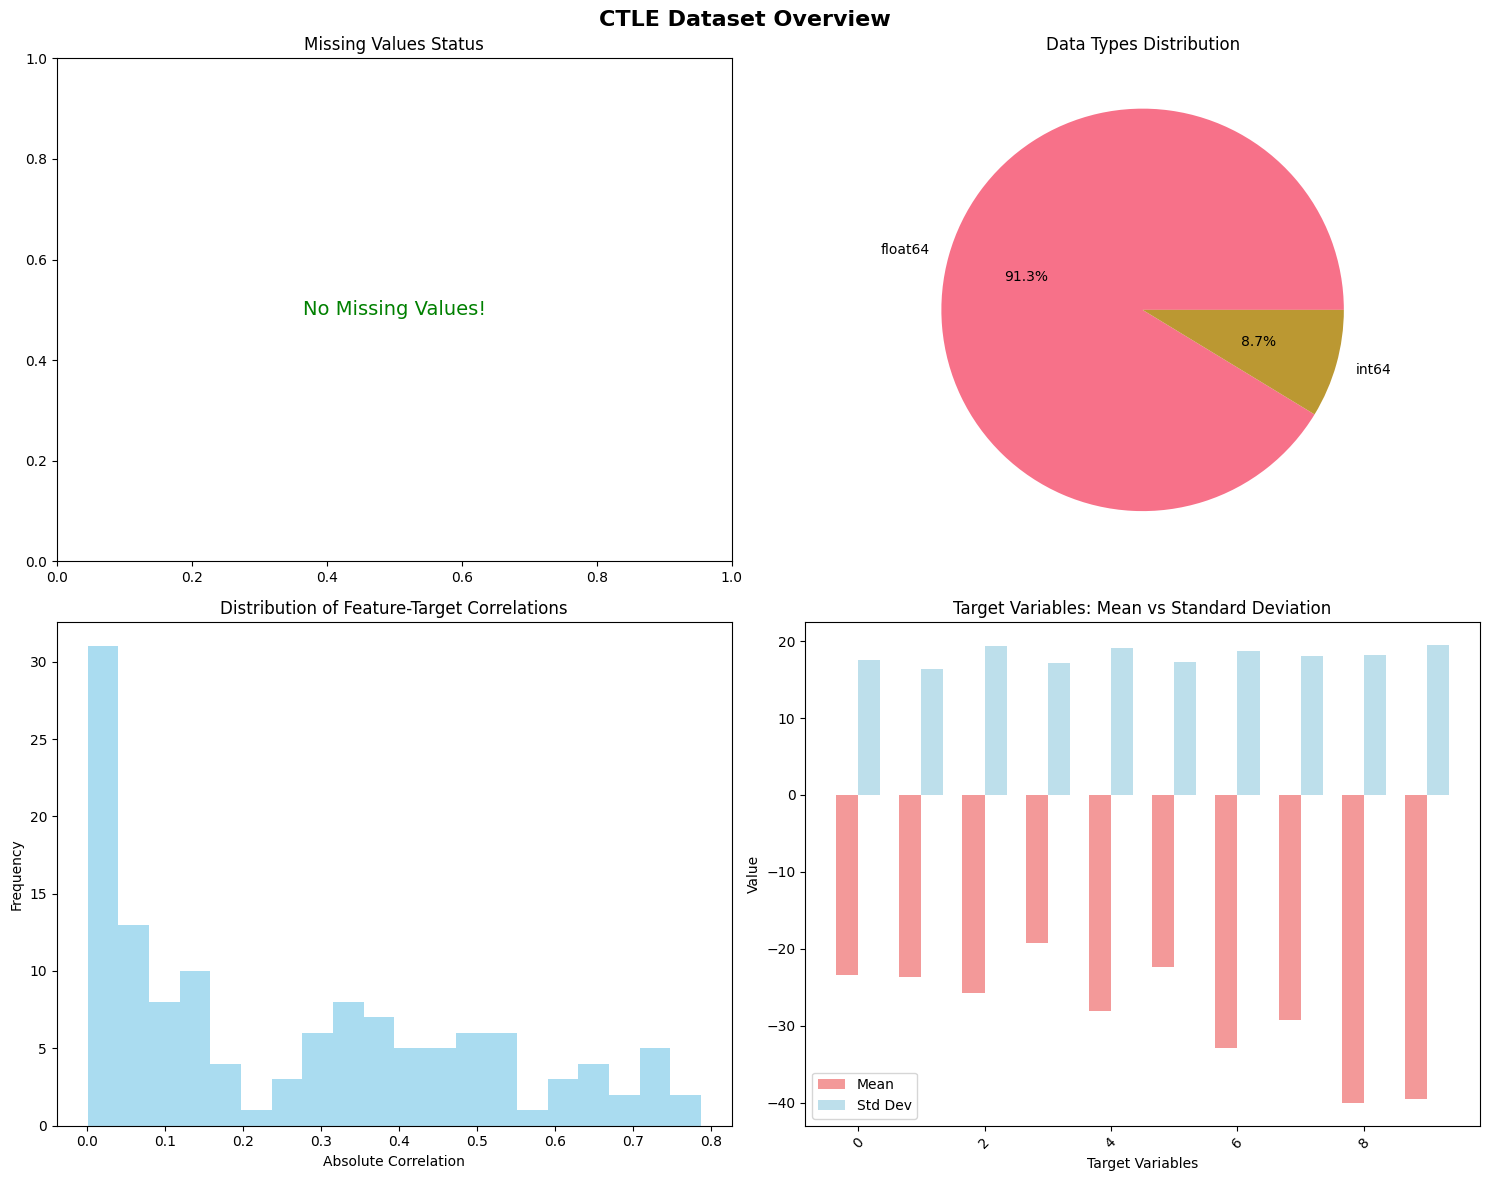

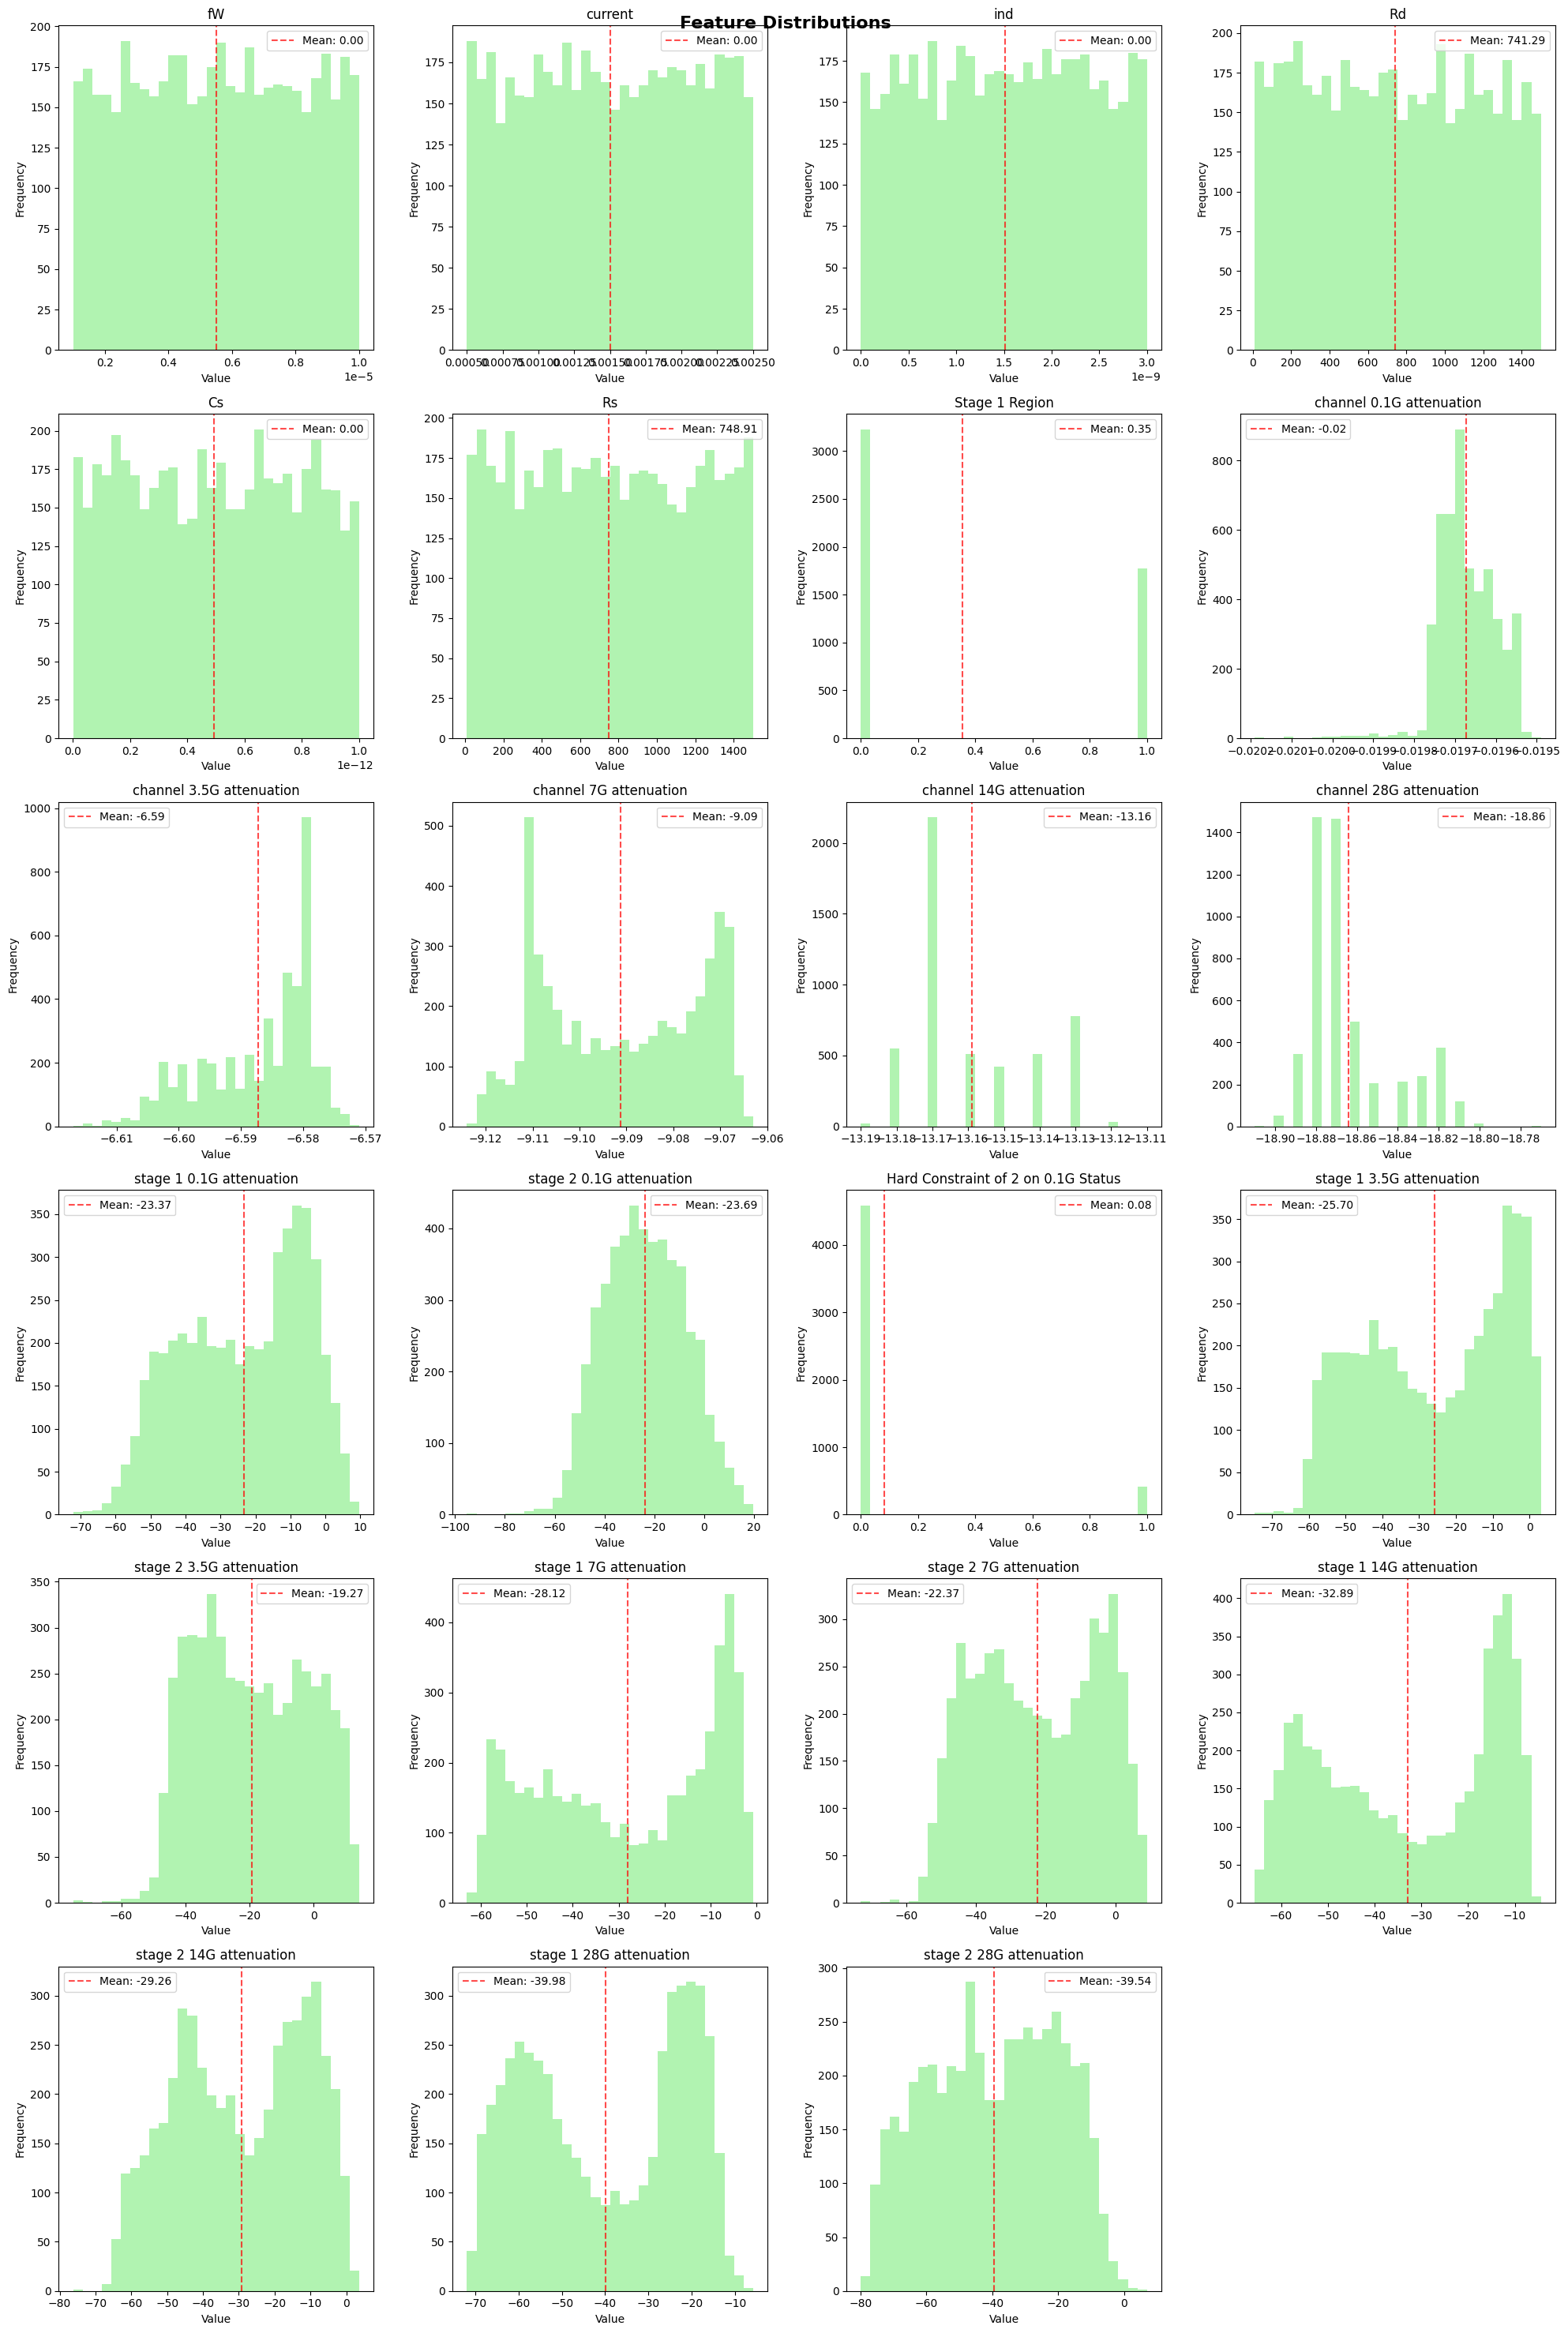

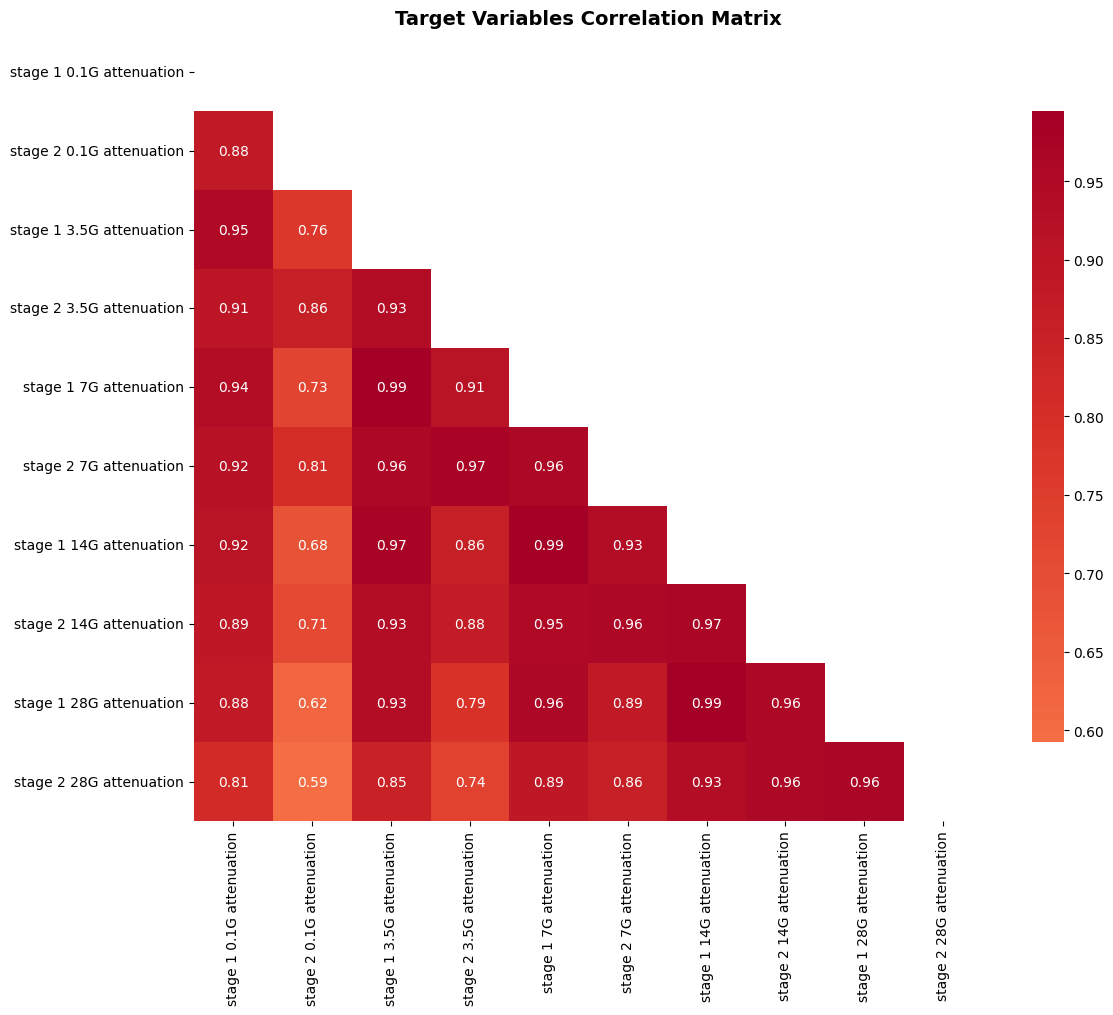

  Numerical features: 11
  Categorical features: 2


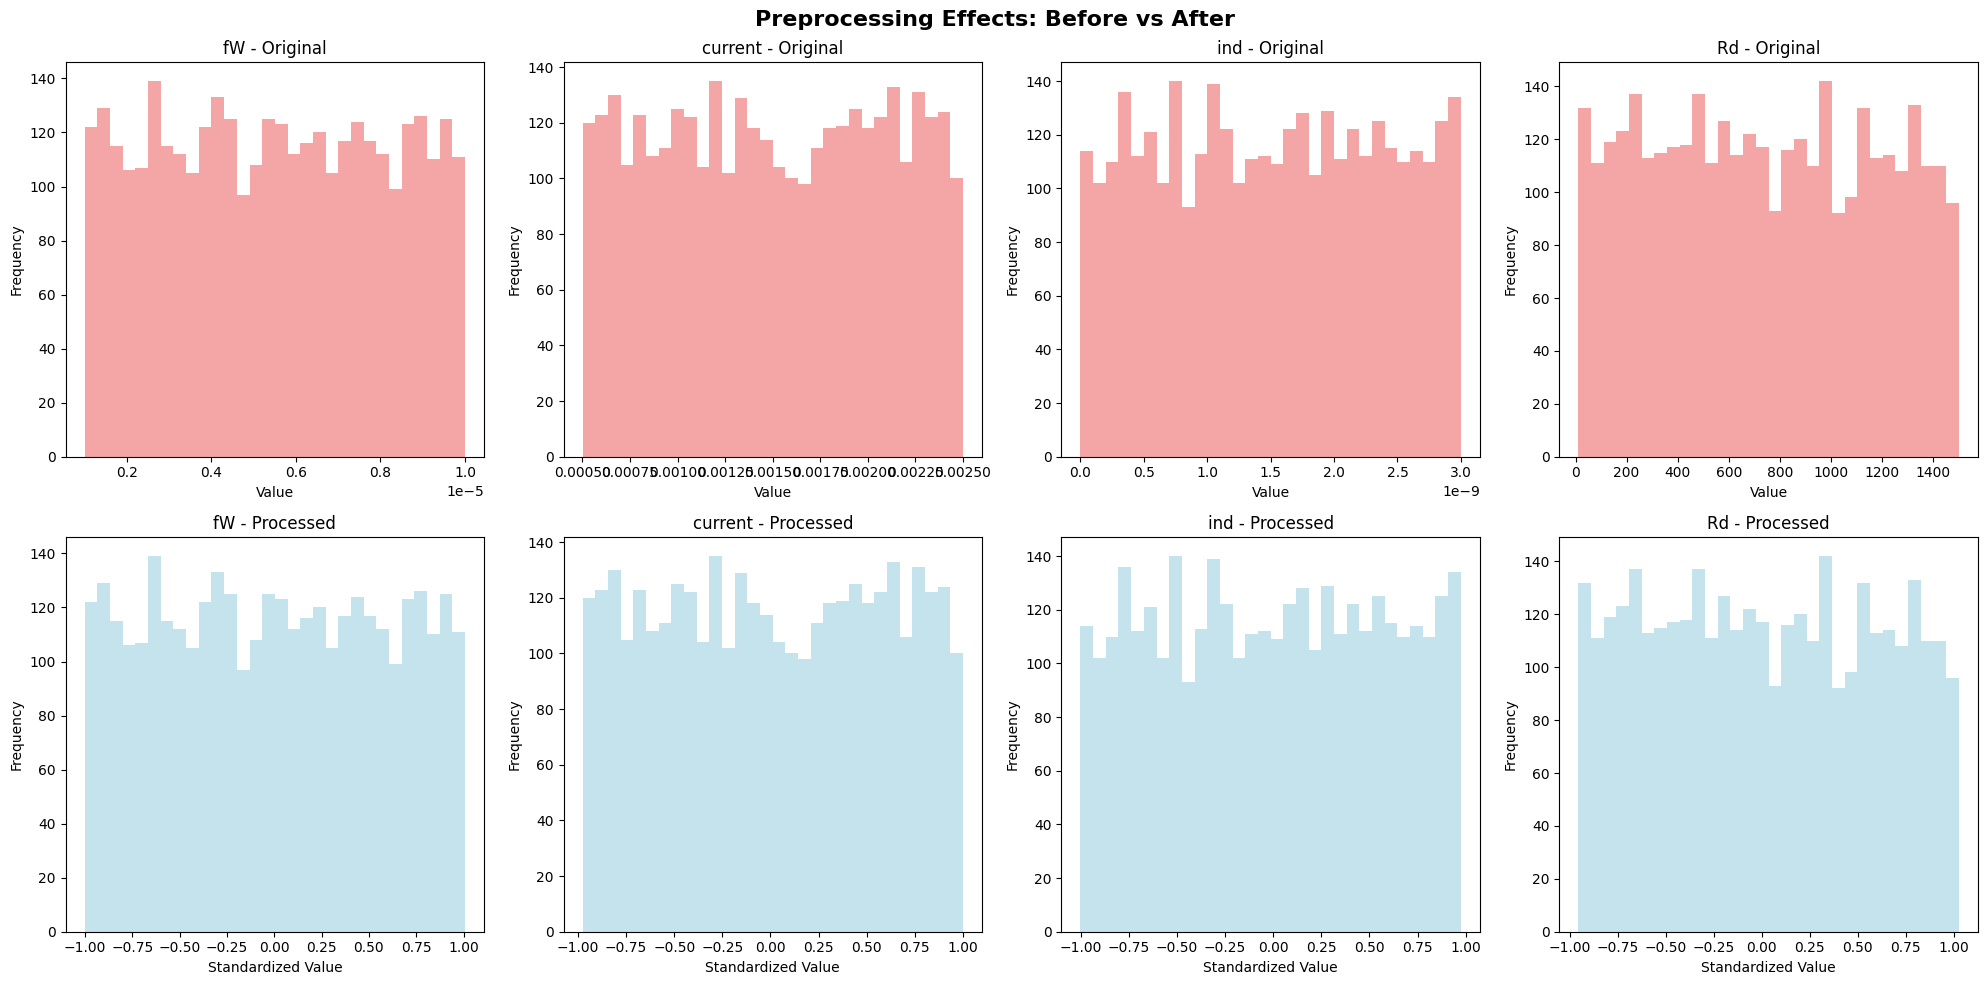

  Training XGBoost...

XGBoost RESULTS
Overall Performance:
  RMSE: 1.9127
  MAE:  1.3256
  R²:   0.9886

Top 3 Target Performance:
  stage 1 28G attenuation: R²=0.9931, RMSE=1.5020
  stage 1 14G attenuation: R²=0.9921, RMSE=1.6530
  stage 2 28G attenuation: R²=0.9908, RMSE=1.8278


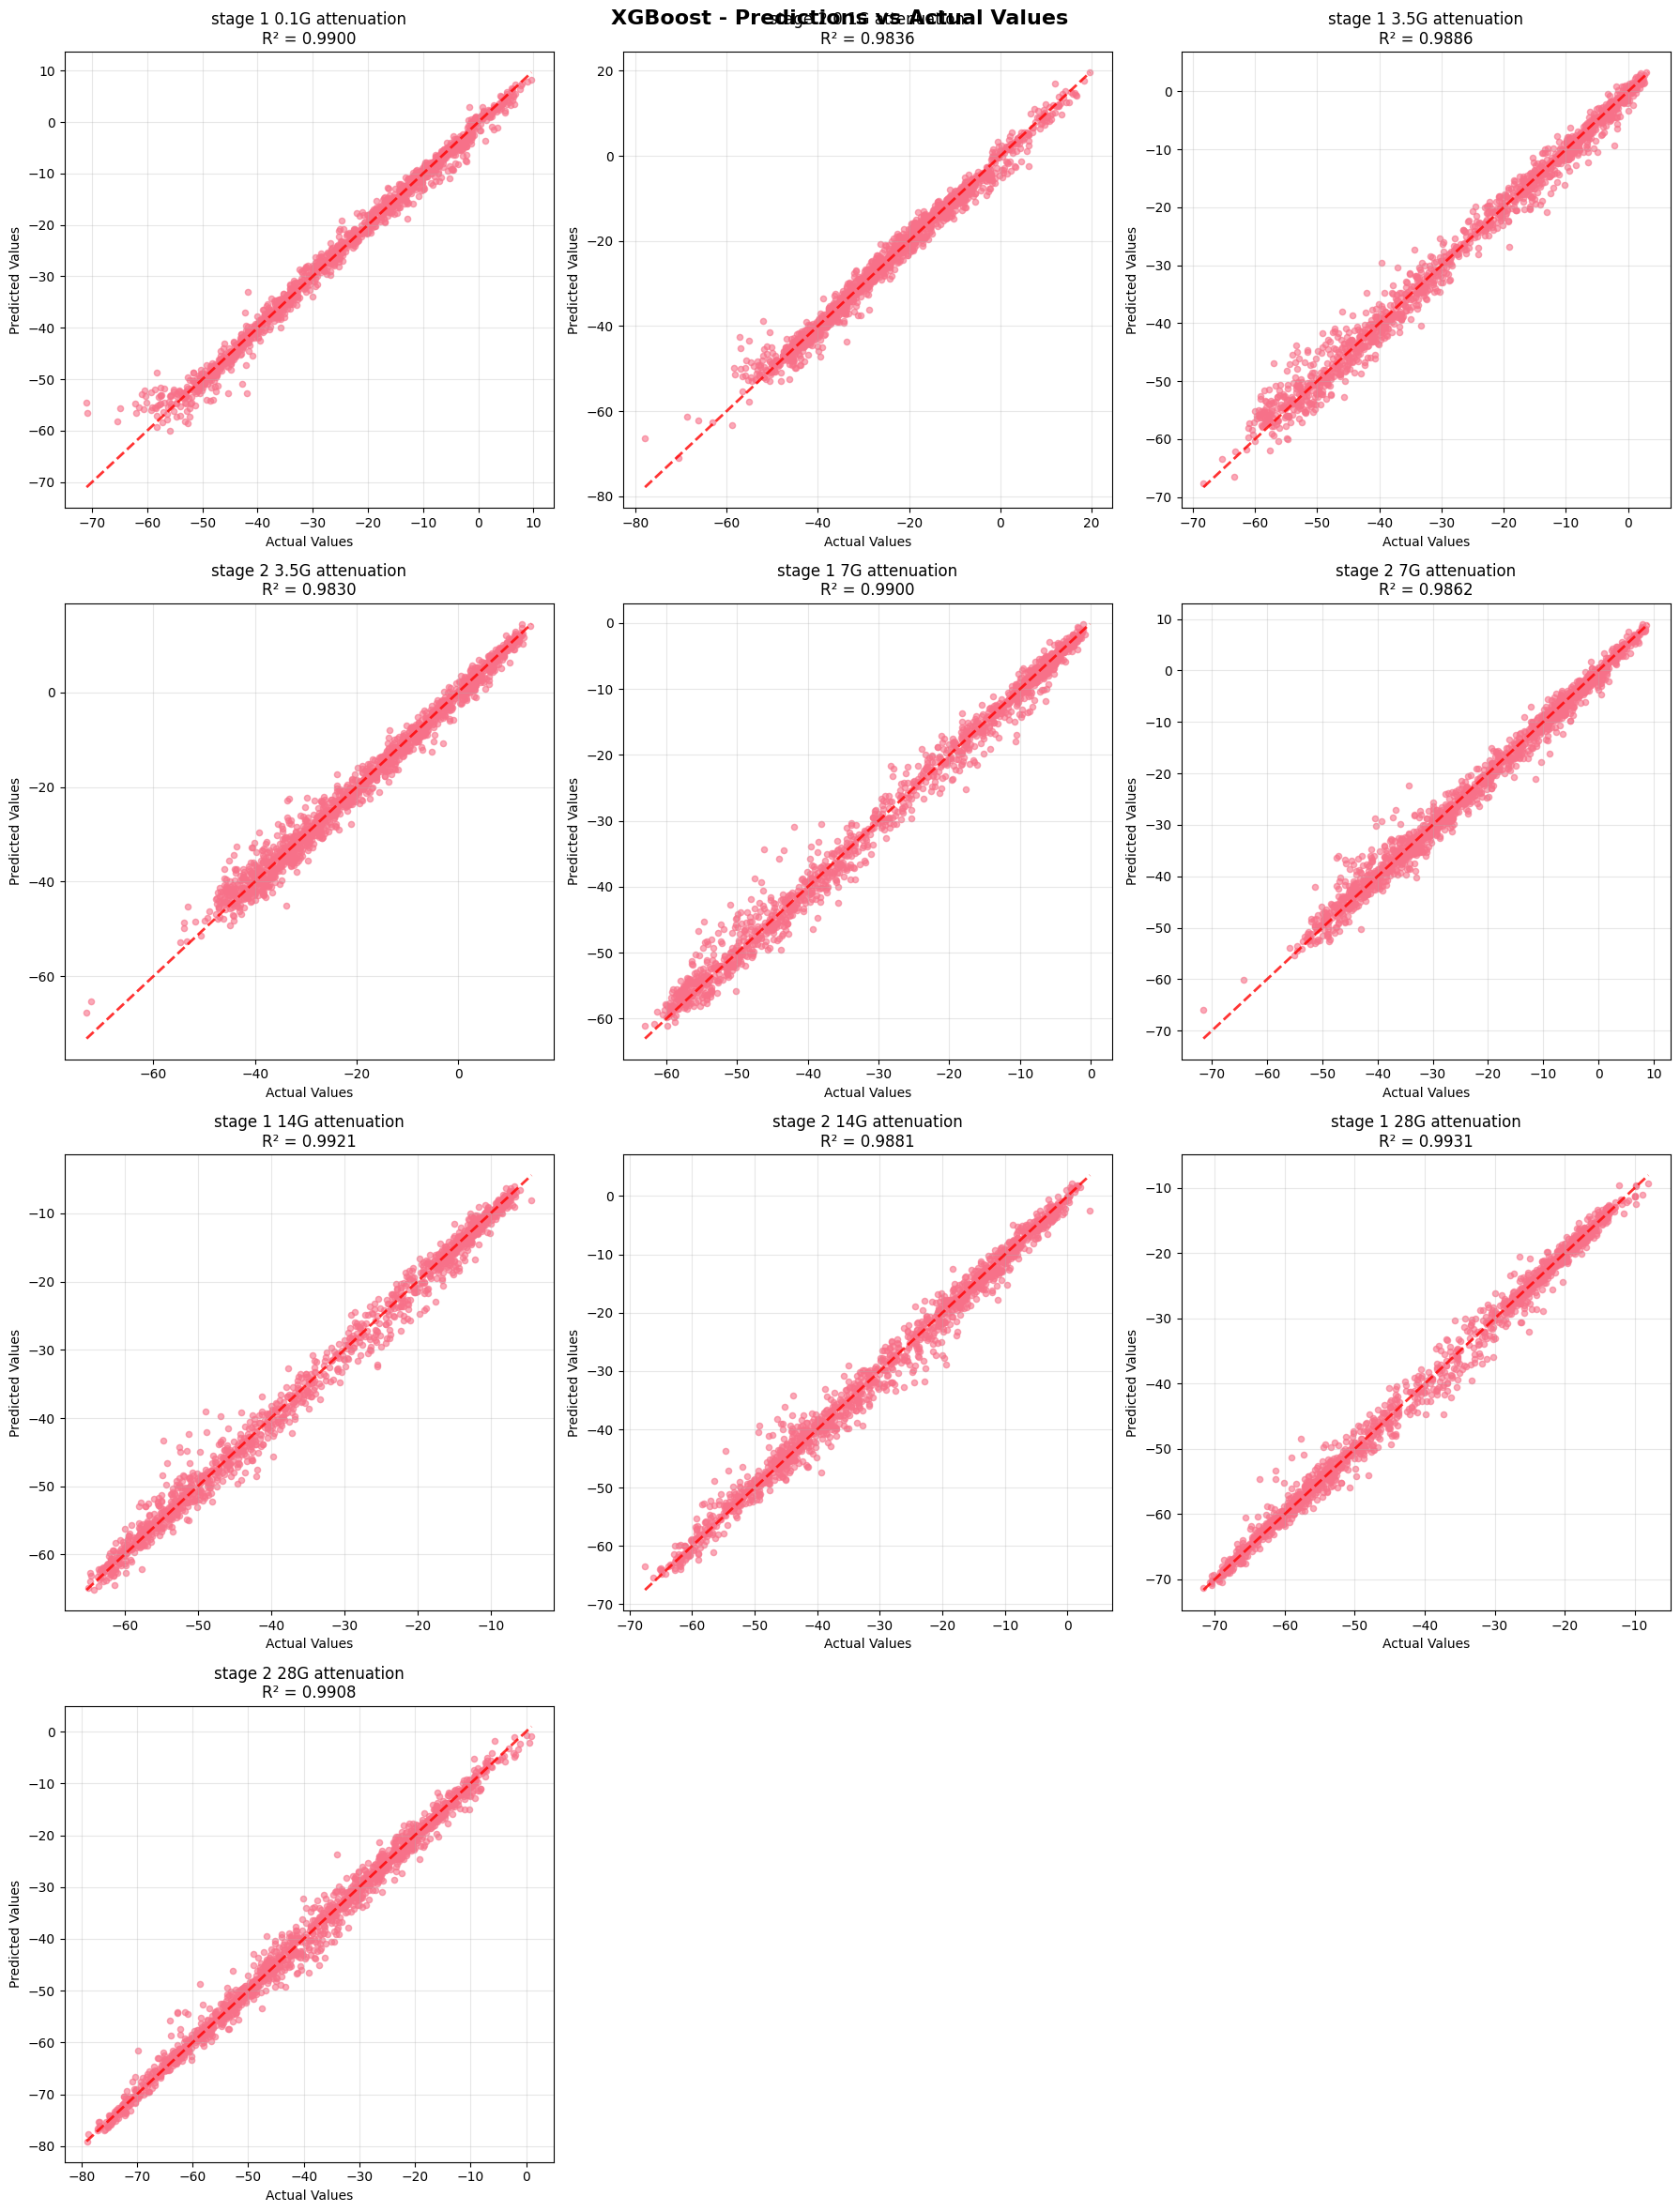

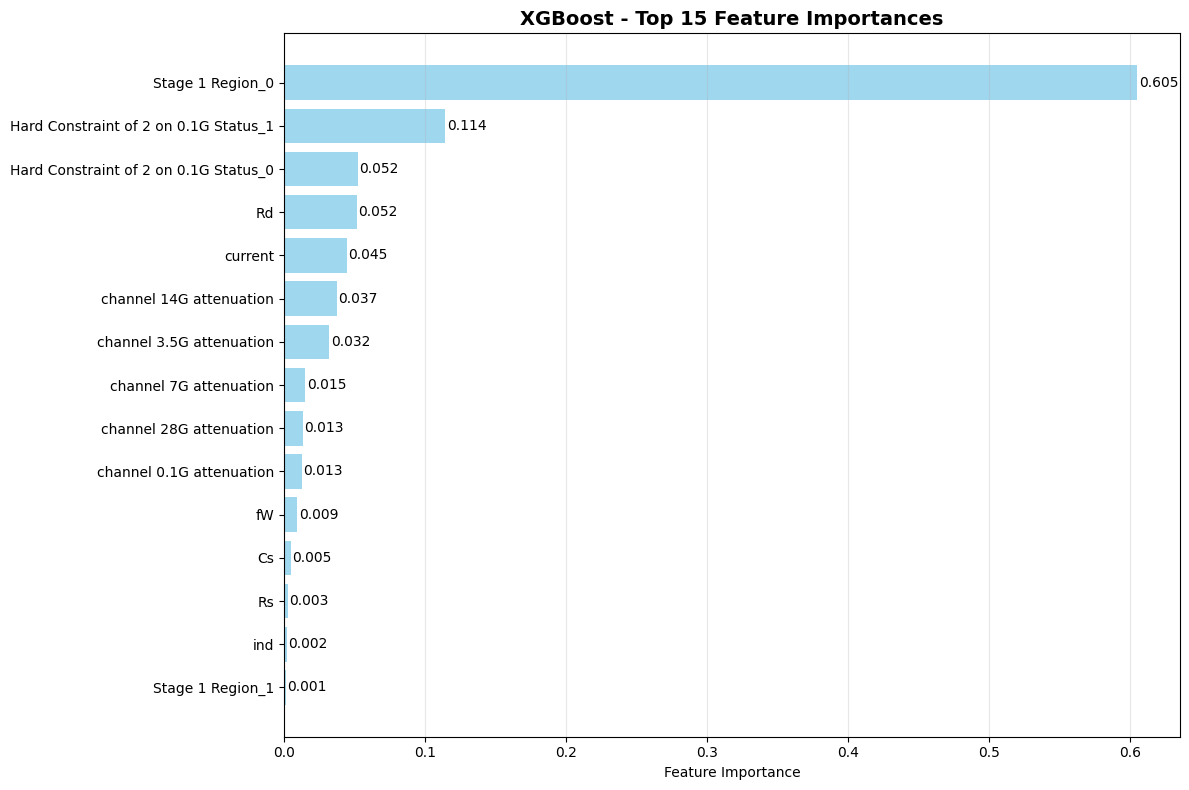

  Training LightGBM...

LightGBM RESULTS
Overall Performance:
  RMSE: 2.0399
  MAE:  1.4271
  R²:   0.9870

Top 3 Target Performance:
  stage 1 28G attenuation: R²=0.9920, RMSE=1.6165
  stage 1 14G attenuation: R²=0.9904, RMSE=1.8237
  stage 2 28G attenuation: R²=0.9890, RMSE=2.0035


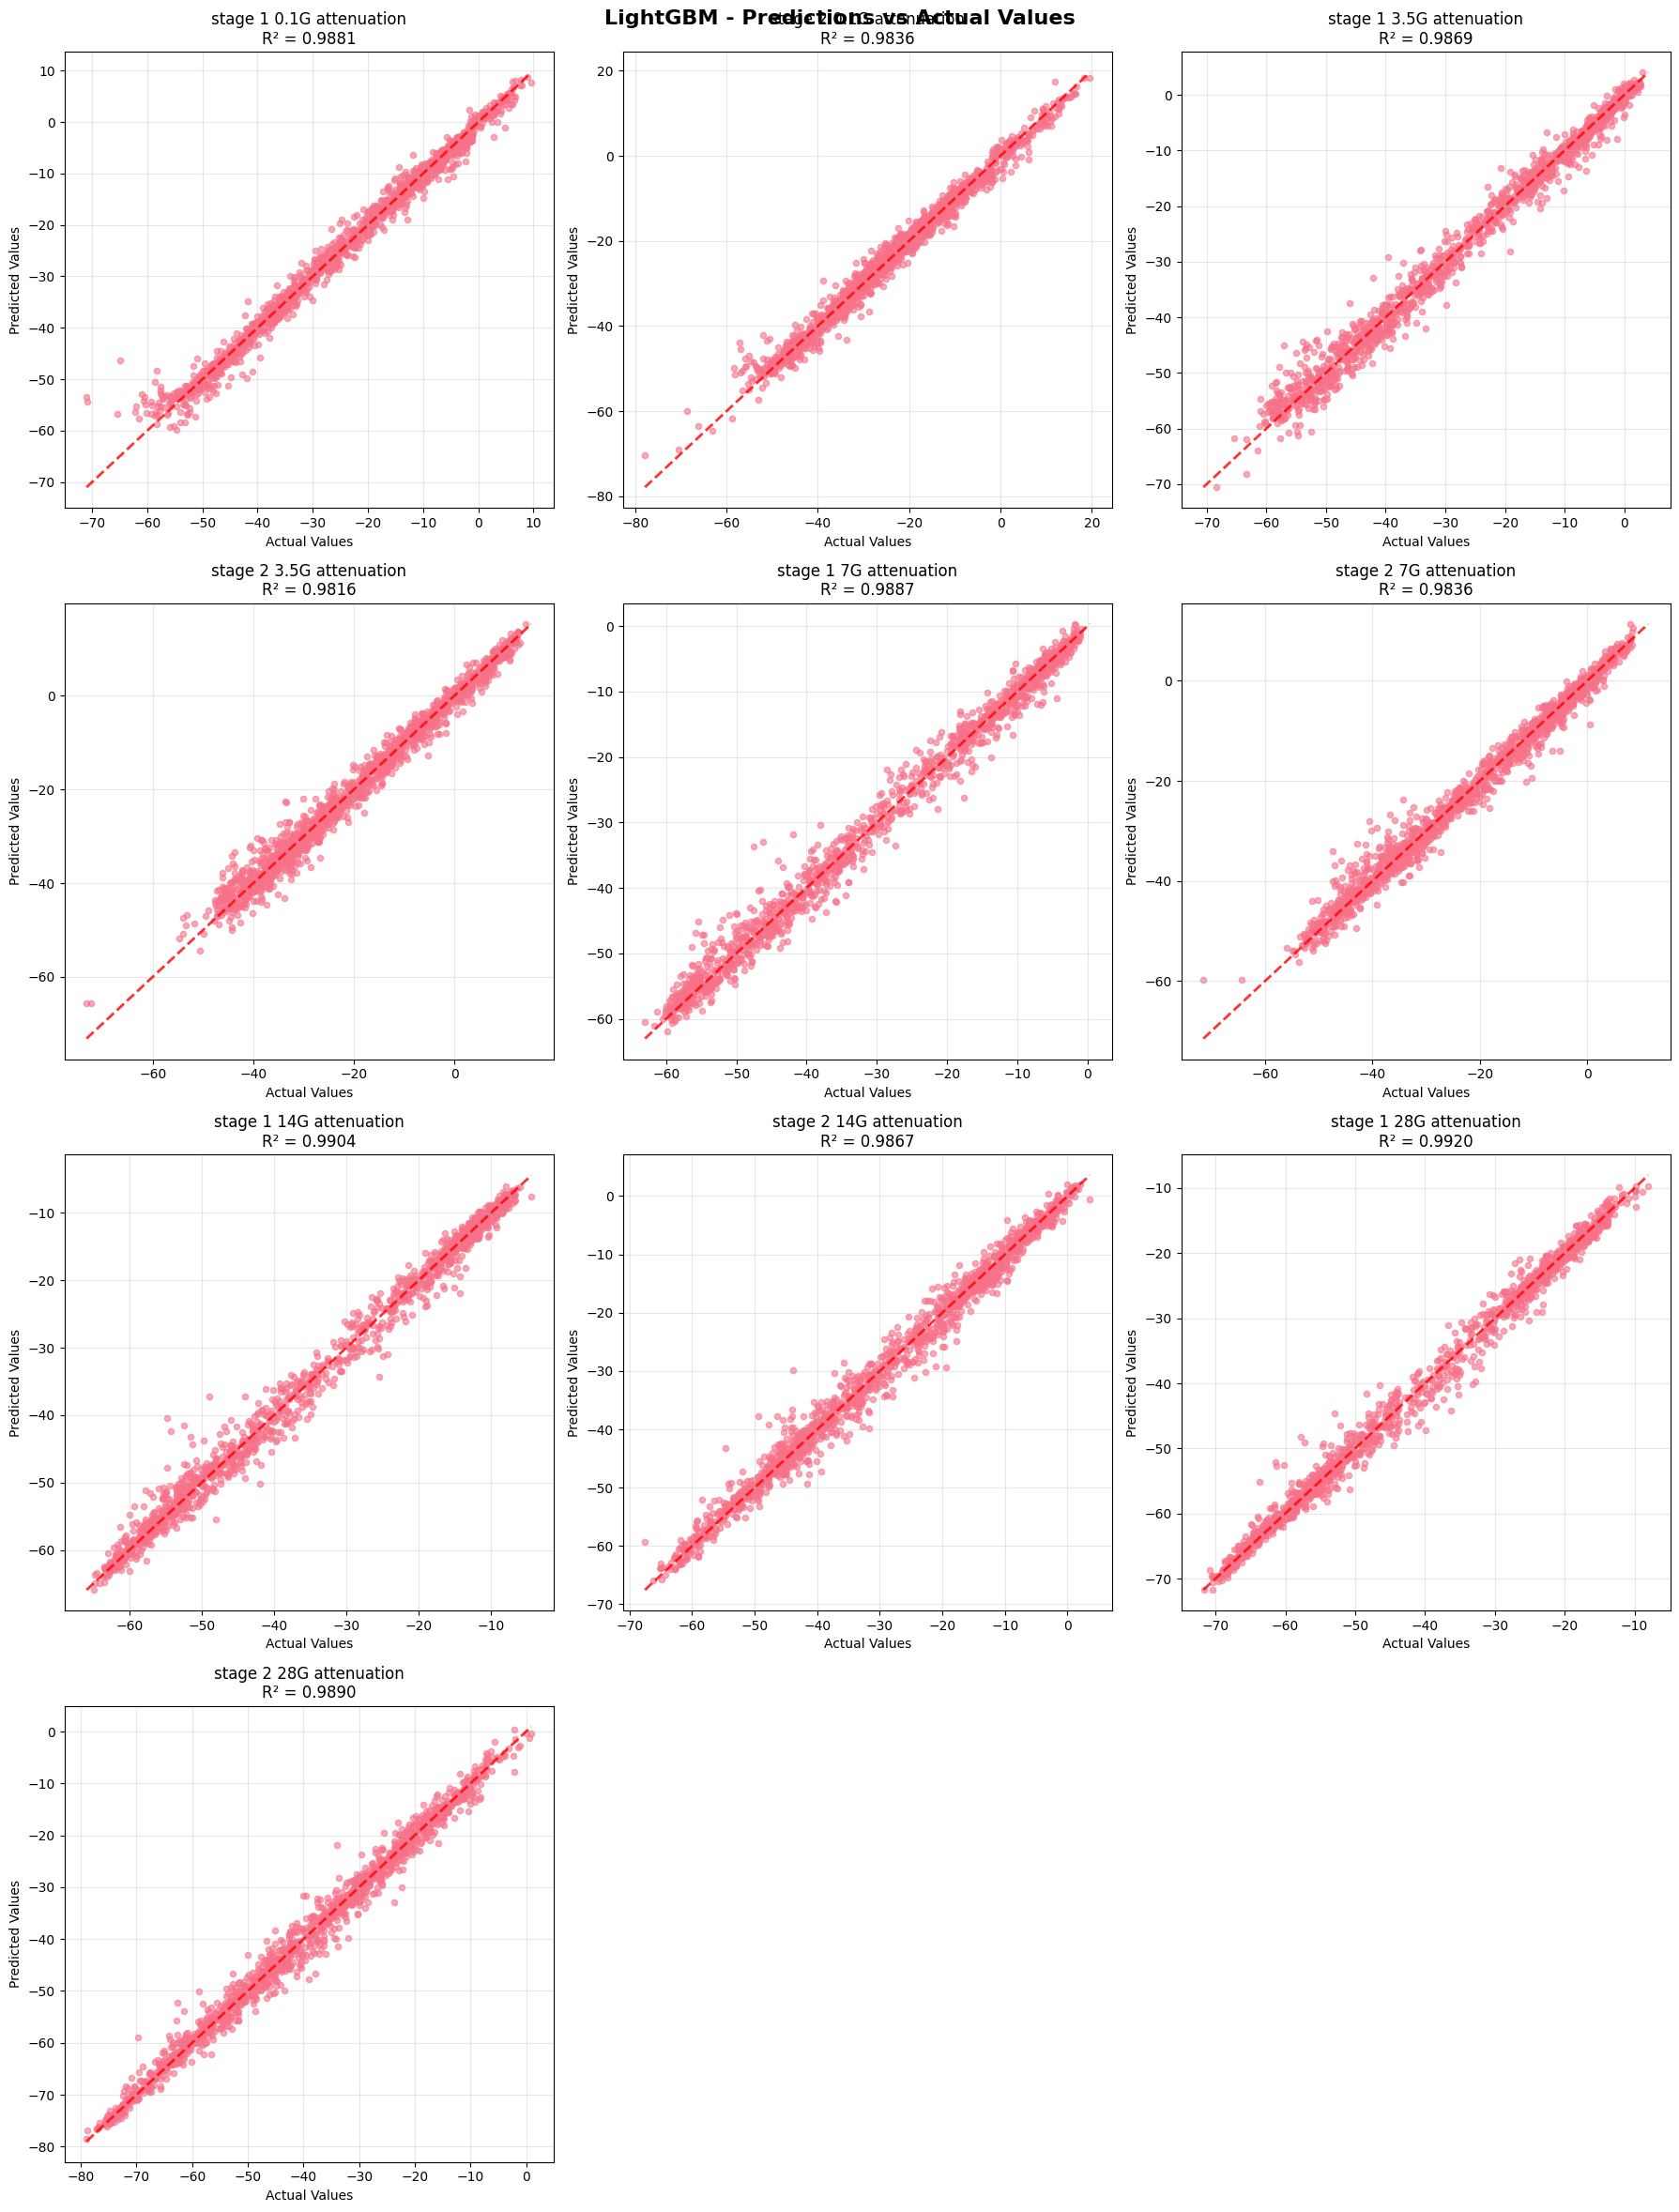

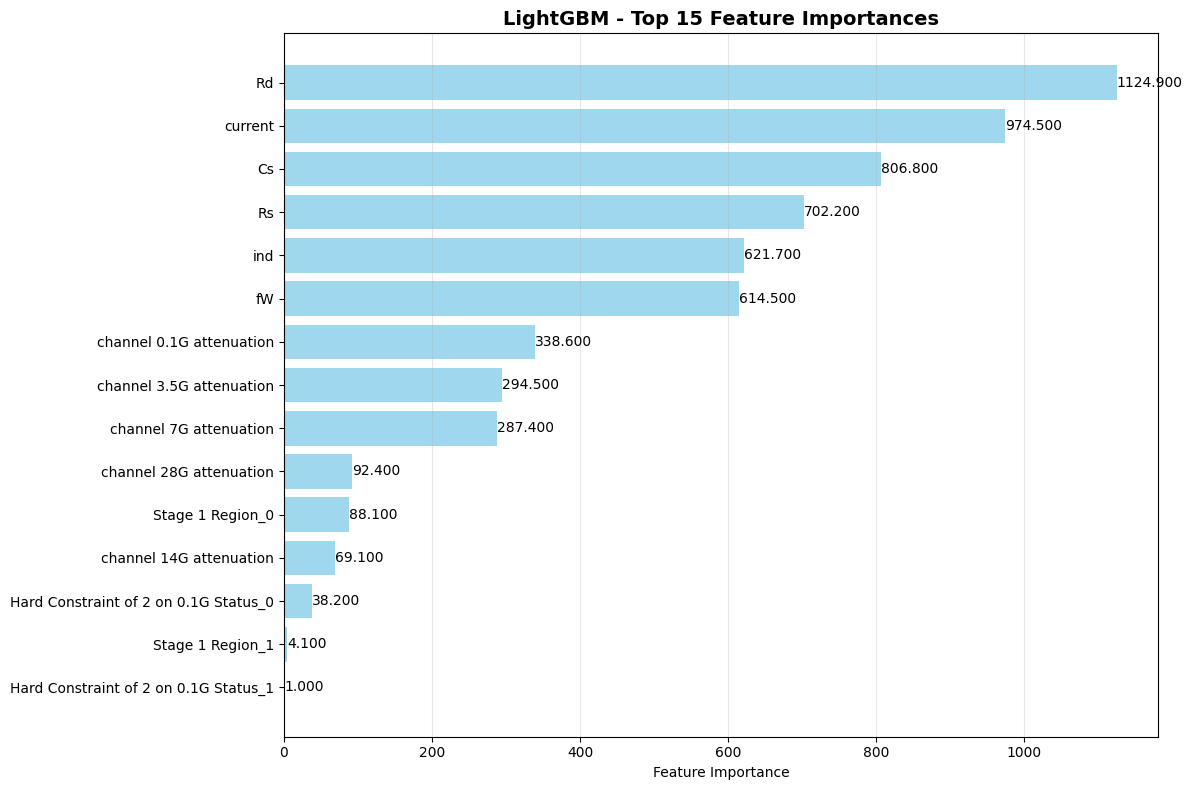

  Training MLP...

MLP RESULTS
Overall Performance:
  RMSE: 0.8977
  MAE:  0.4891
  R²:   0.9974

Top 3 Target Performance:
  stage 1 7G attenuation: R²=0.9987, RMSE=0.6835
  stage 1 14G attenuation: R²=0.9986, RMSE=0.6990
  stage 1 3.5G attenuation: R²=0.9986, RMSE=0.7336


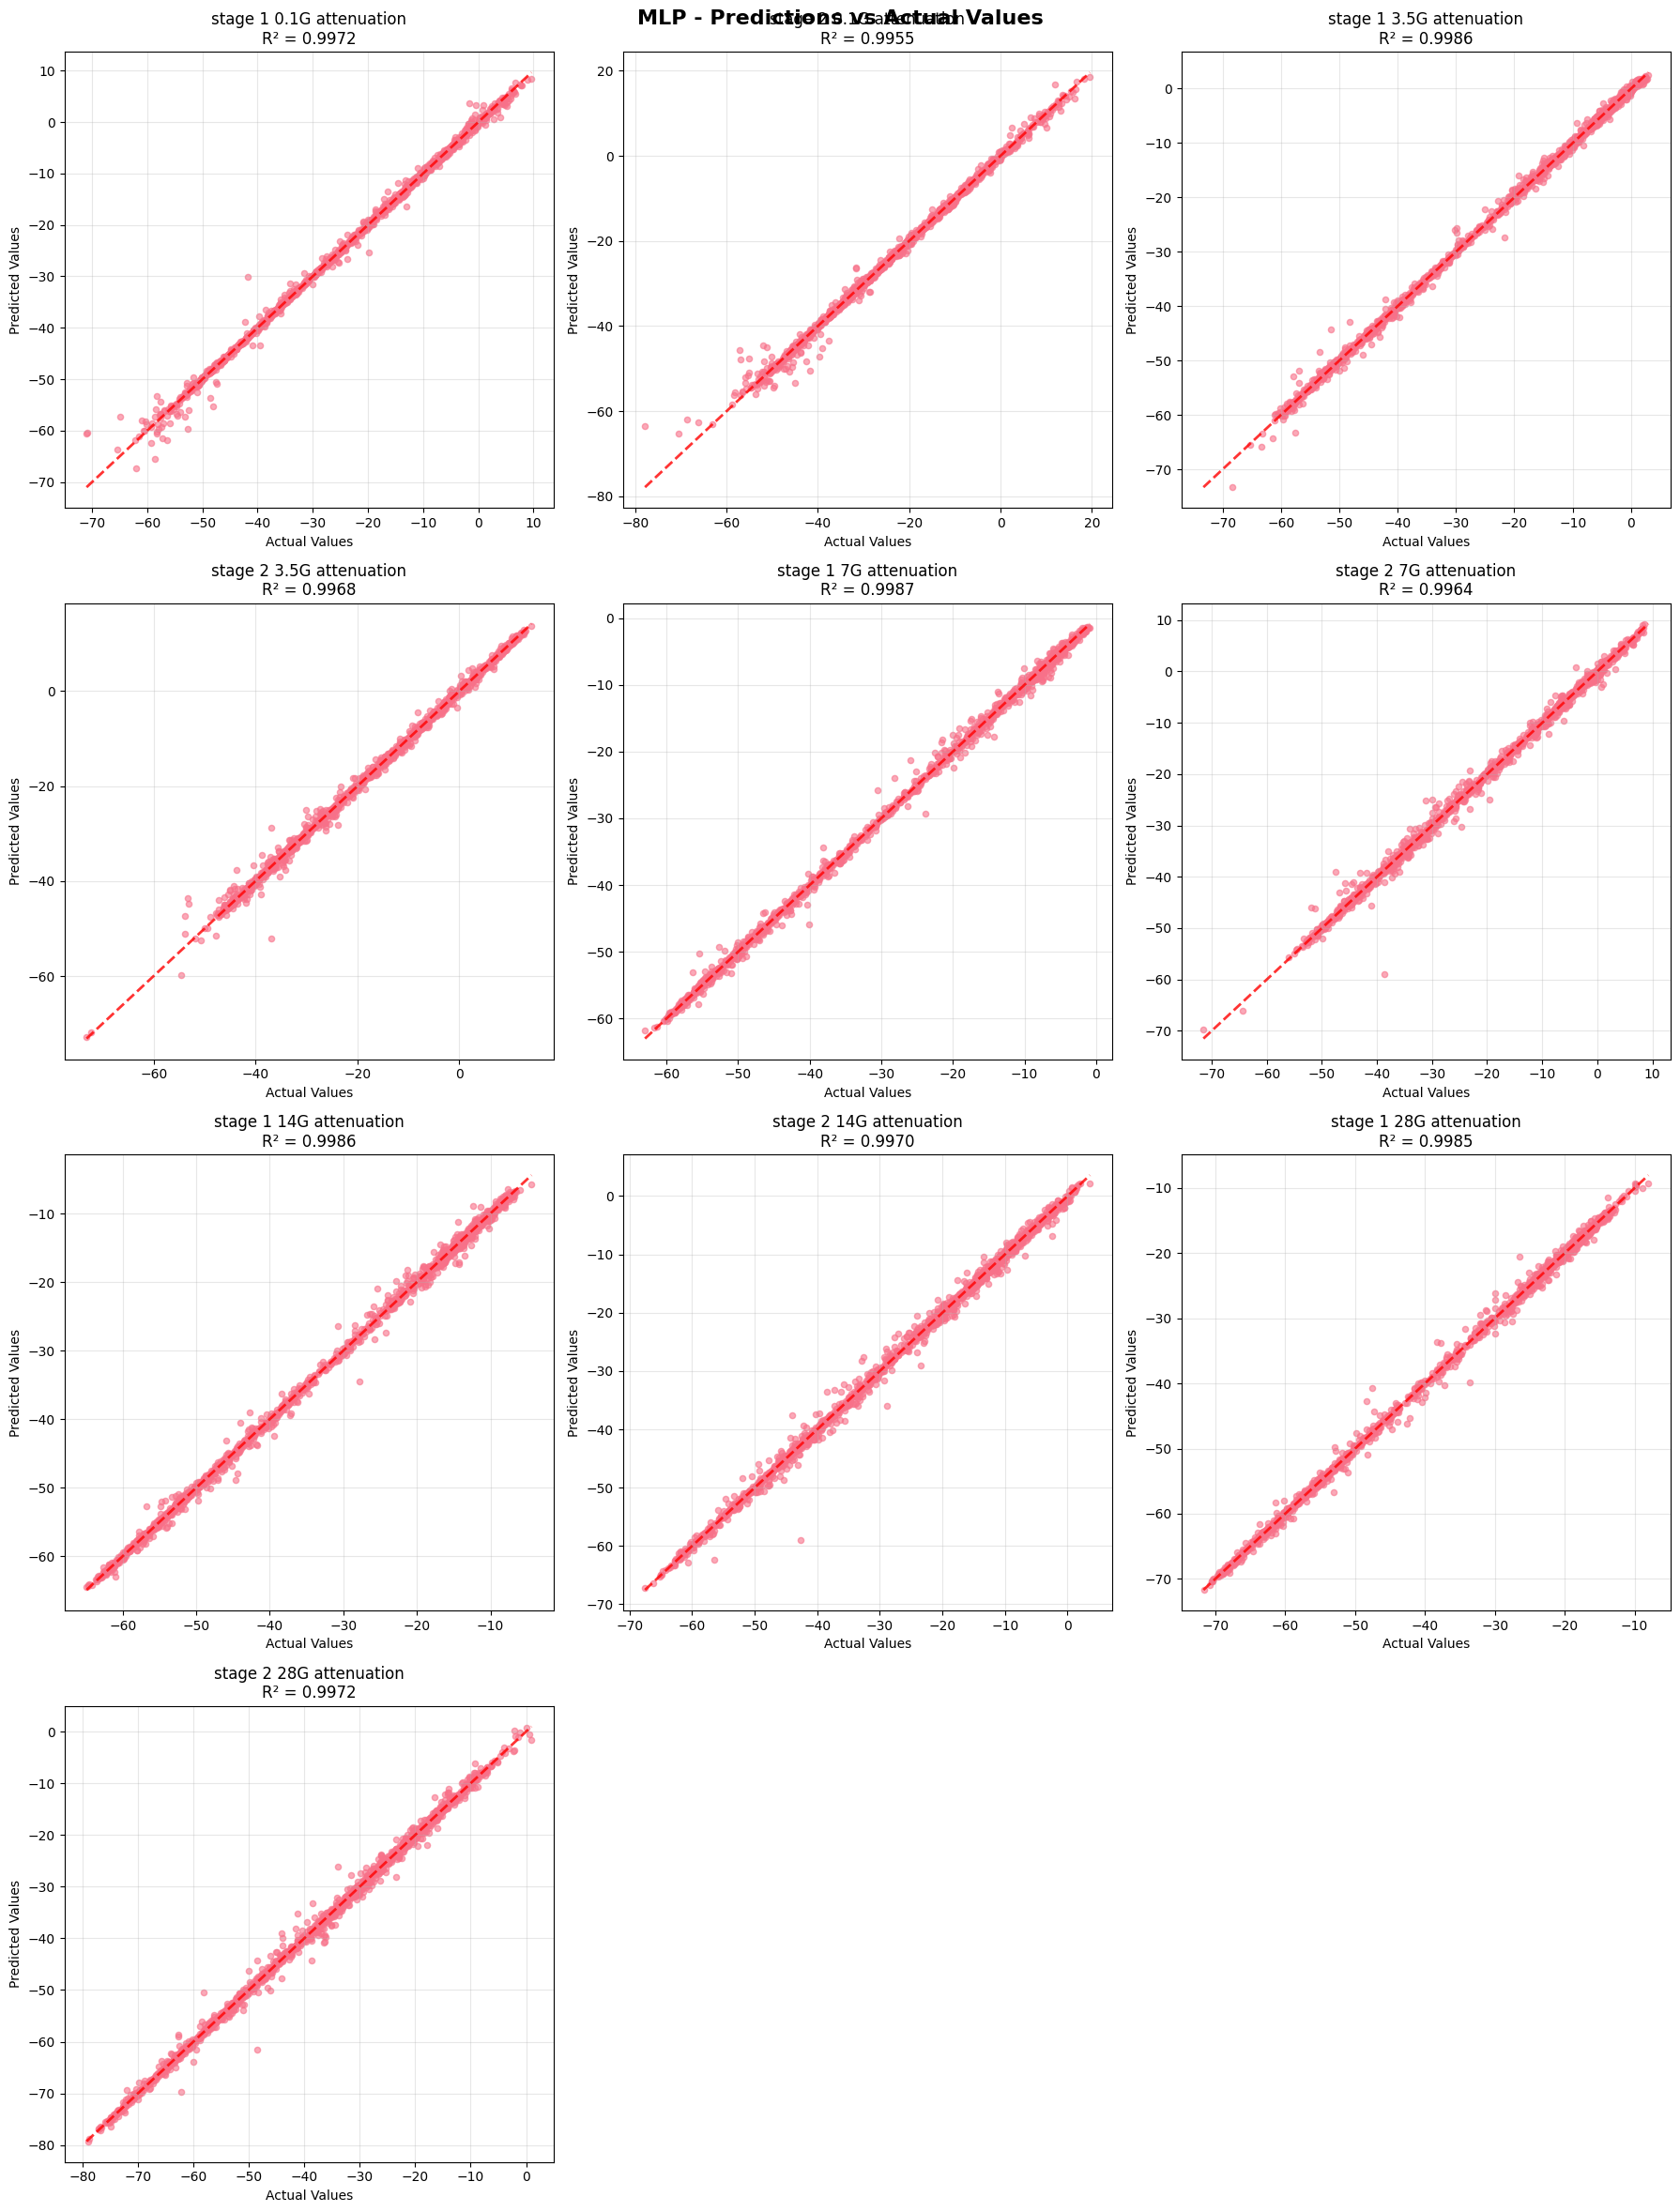

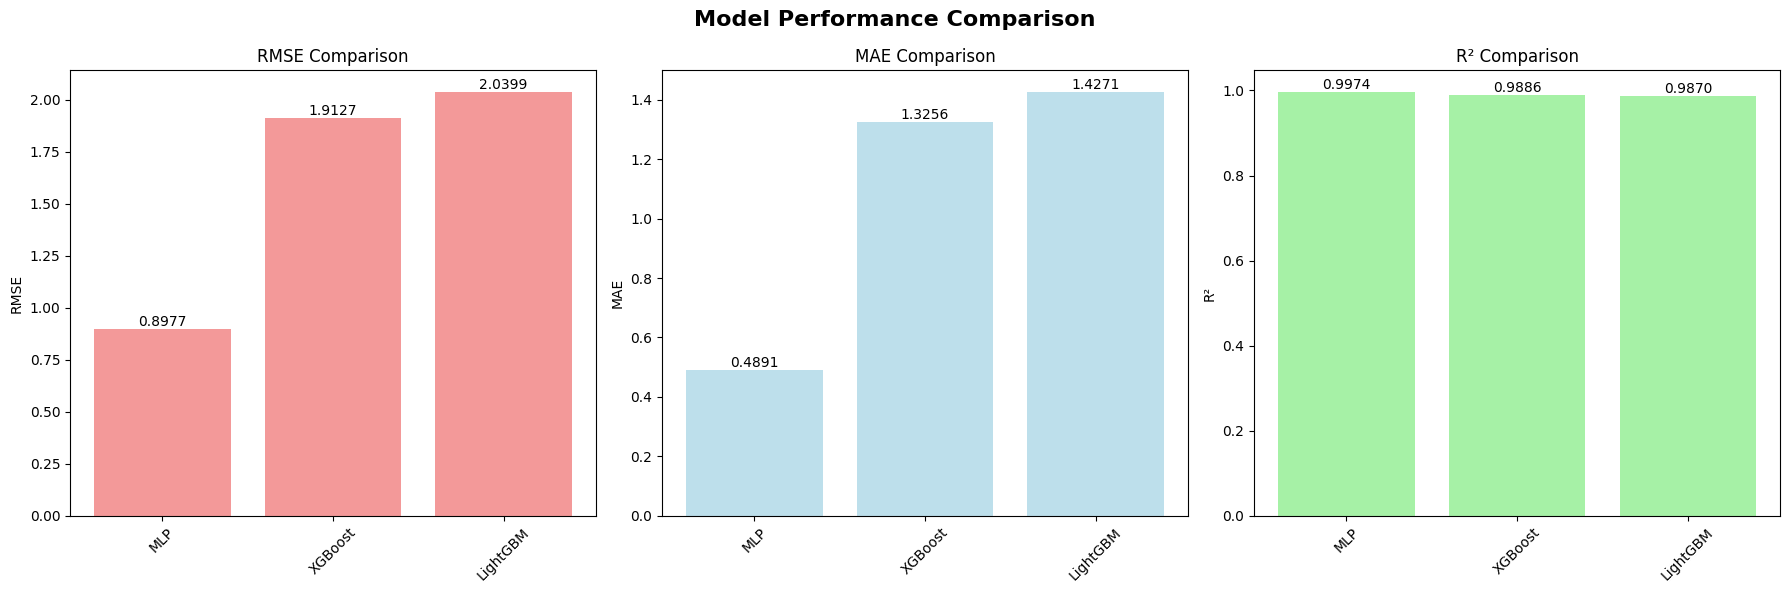

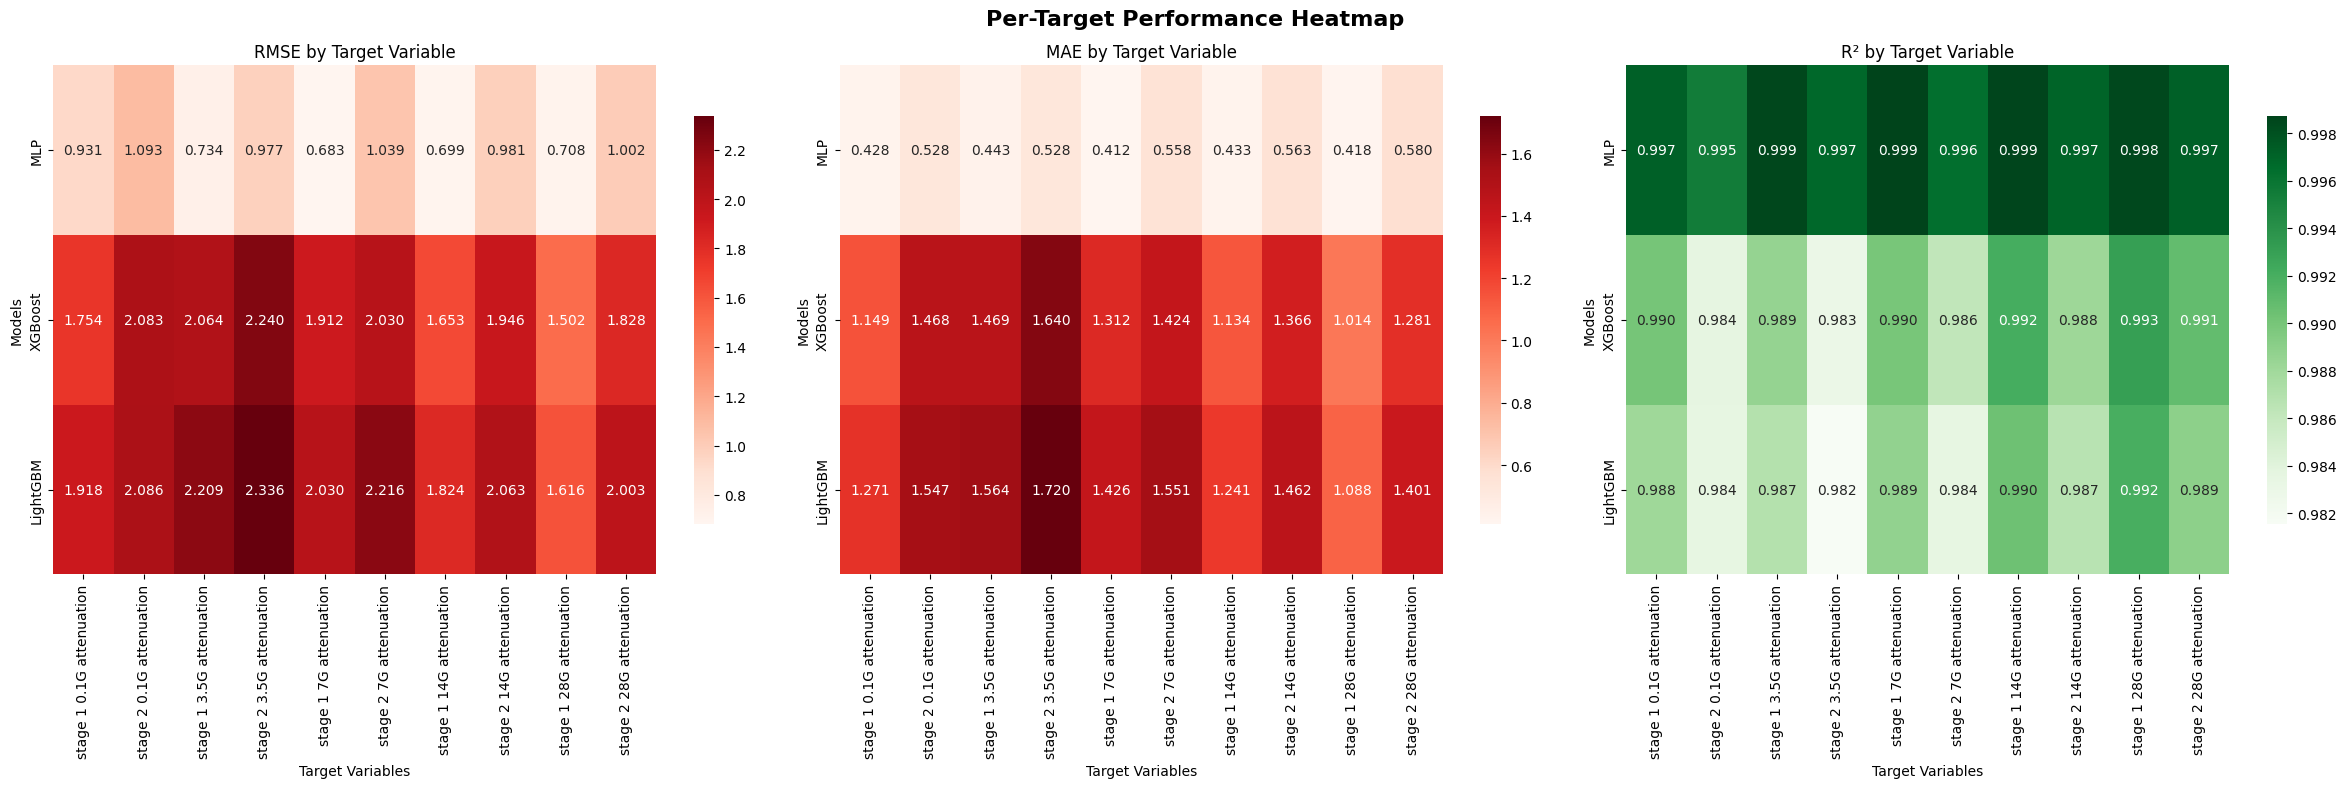

Running 20 optimization tests...


100%|██████████| 20/20 [01:01<00:00,  3.07s/it]



Optimization Summary:
Success rate: 95.0%
  Mean MSE error: 183.697598
  Results saved to: inverse_optimization_results_fixed.csv


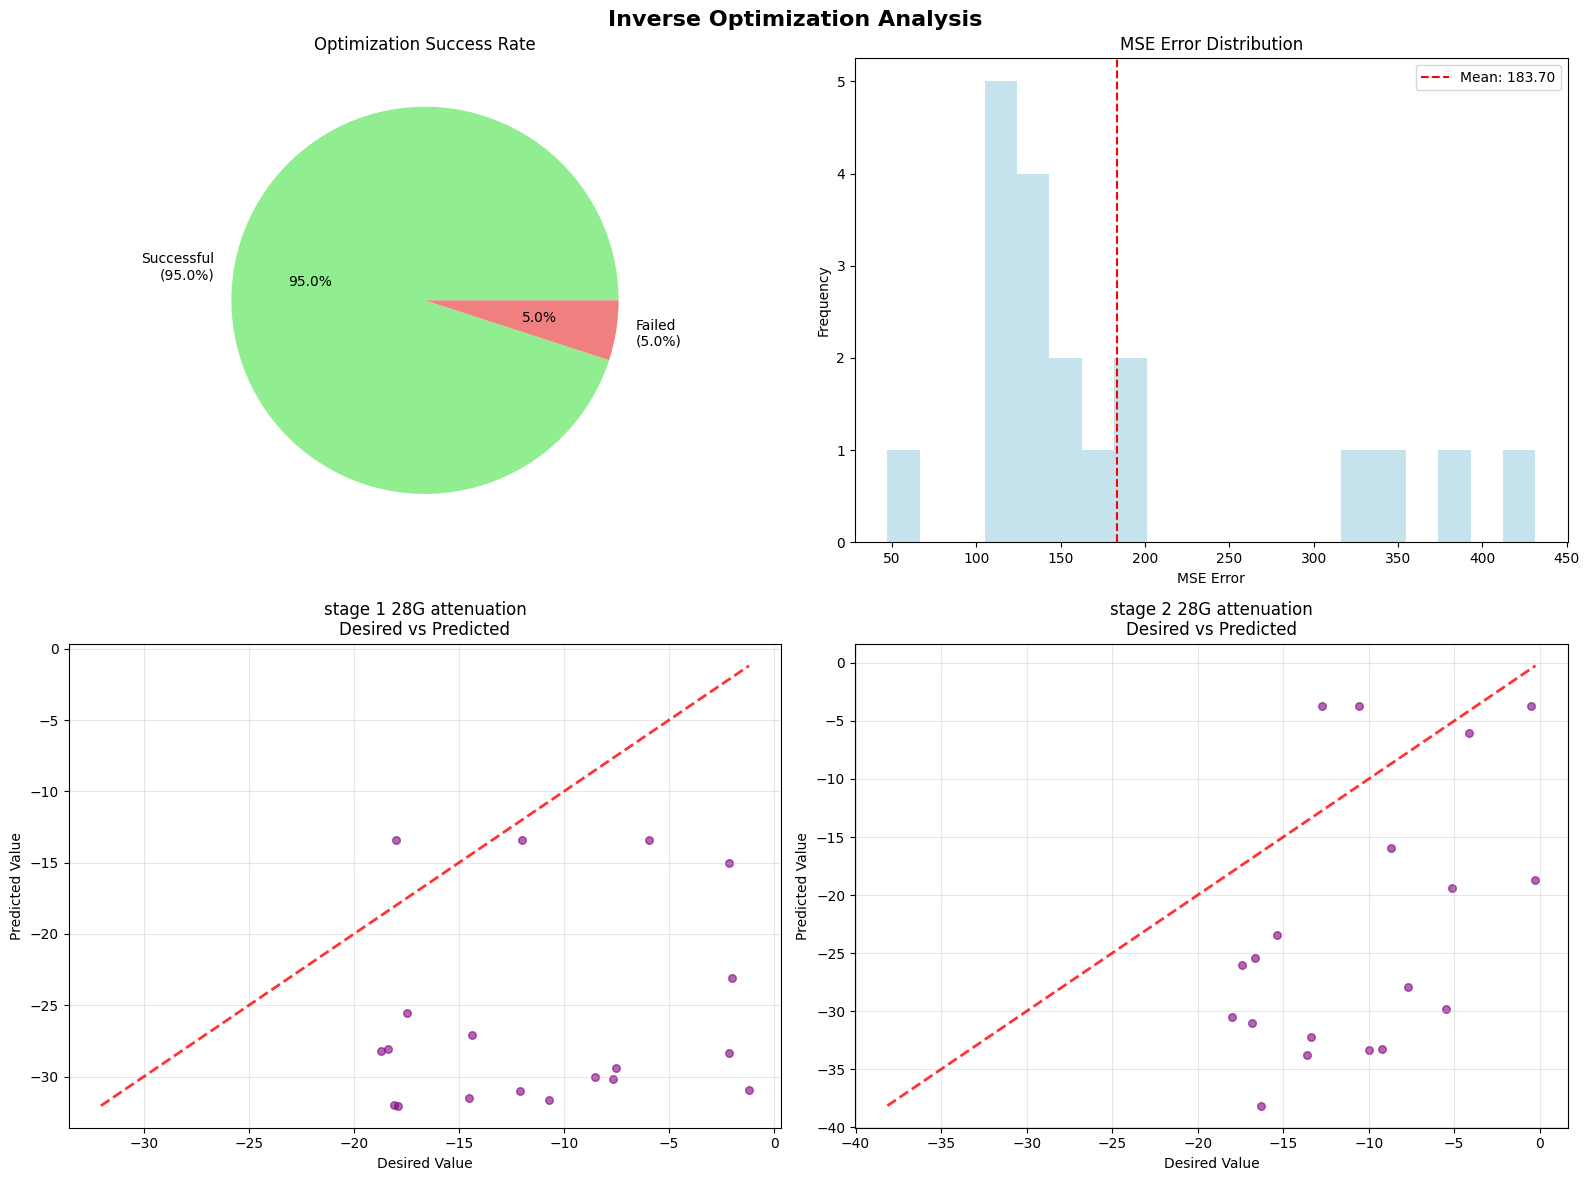

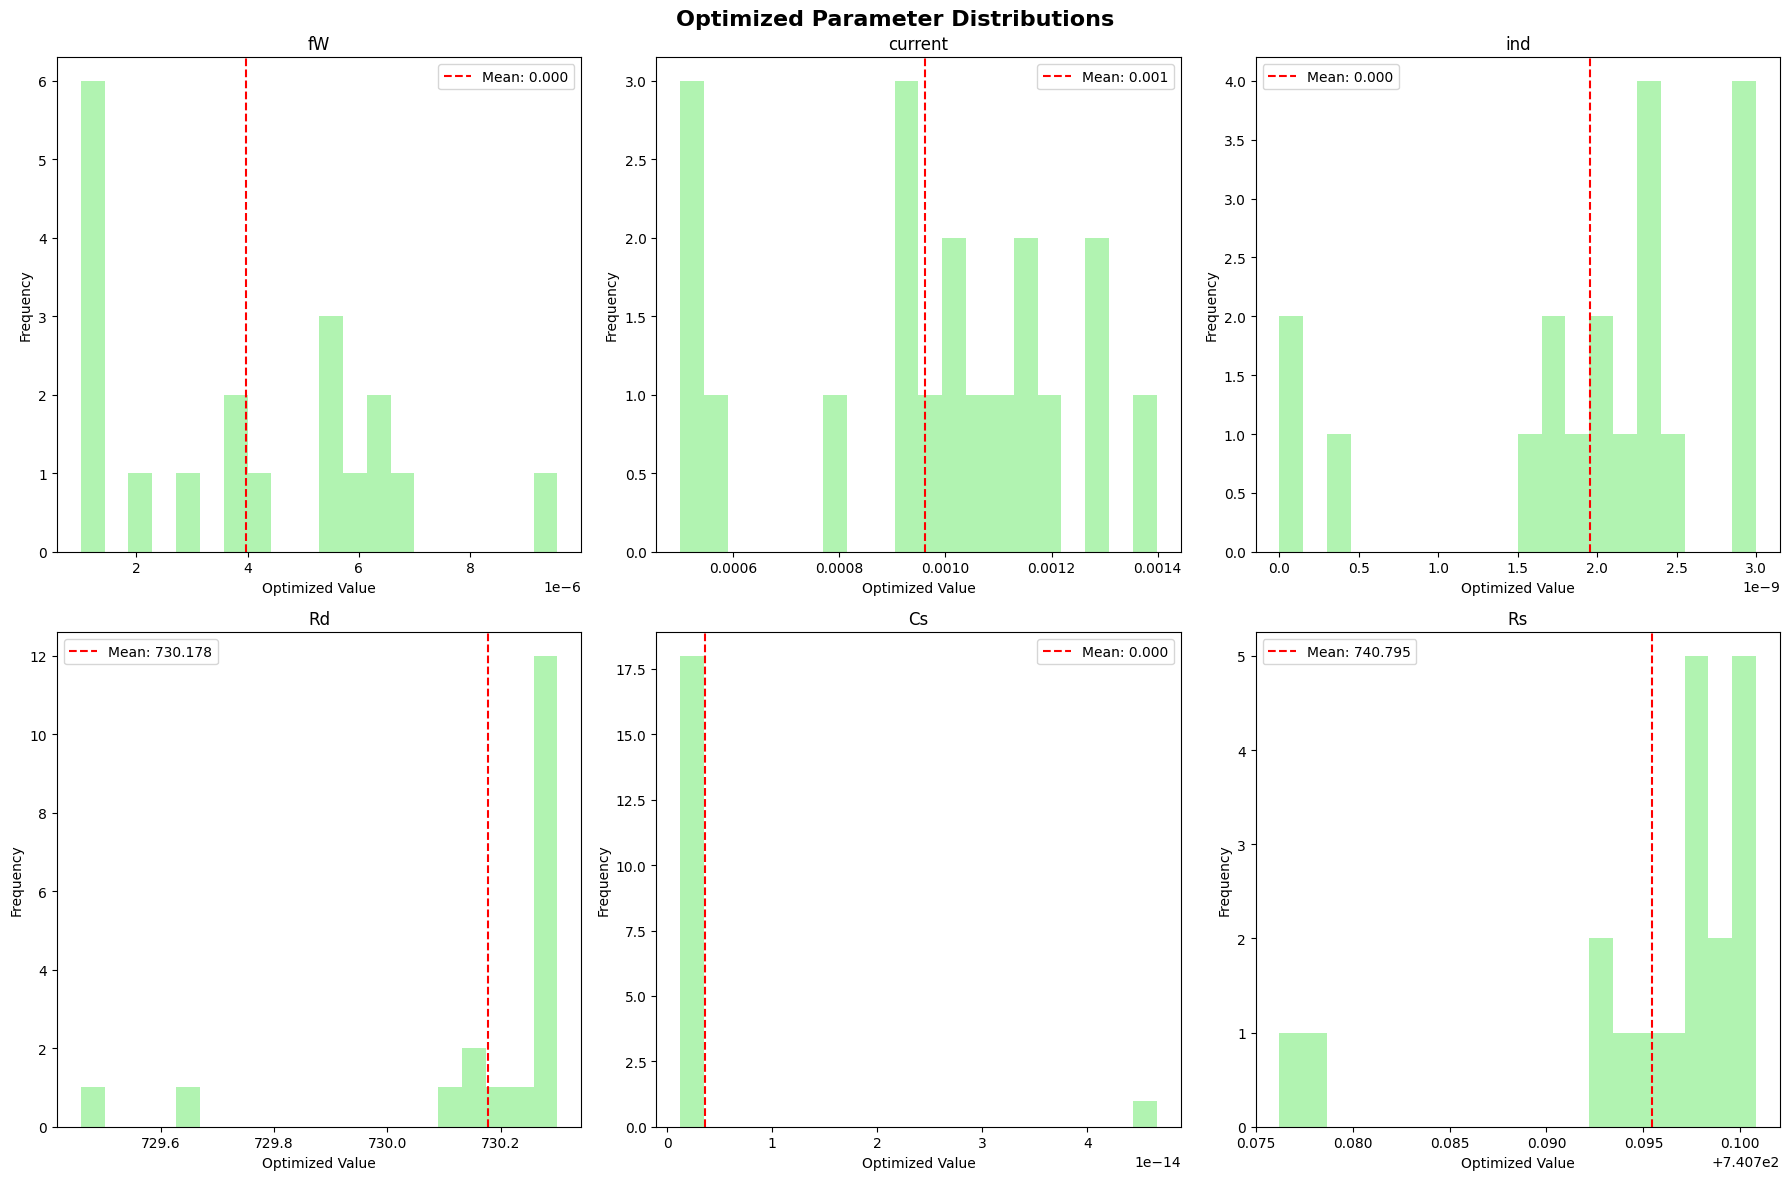

Best model: MLP
Best R² score: 0.9974
Inverse optimization: 20 tests completed
Models and Plots saved to: ctle_circuit_generation_with_DNN_models_V1/
Total execution time: 0:03:02.483142


In [61]:
if __name__ == "__main__":
    training_results, optimization_results = main()